# Predicción de Resultados de LaLiga con Ponderación Temporal

Este notebook implementa un modelo predictivo para los partidos de la Primera División de fútbol. El objetivo es predecir el resultado (victoria local, empate o victoria visitante) en cada encuentro utilizando:
- **Características de forma reciente:** Estadísticas de los últimos 5 partidos.
- **Enfrentamientos directos recientes:** Estadísticas entre los equipos en los últimos 3 años.
- **Rendimiento histórico a largo plazo:** Promedio de puntos en los últimos 5 años.

Se usarán los modelos **Random Forest**, **SVC** y **XGBoost** para entrenar un clasificador multiclase y además con el modelo que mejores resultados ofrezca se realizará una simulación para proyectar la clasificación final a partir de los partidos restantes (últimas 10 jornadas).

> **Nota:** En este notebook se recopilarán los partidos disputados desde la temporada 1993/94 hasta la jornada 28 de la presente temporada 2024/25 (31 temporadas), faltando así 10 jornadas para finalizar el campeonato. Se asume que la recopilación de estos datos contiene al menos las siguientes columnas:  
> - `Date`: Fecha del partido (se parsea como fecha)  
> - `HomeTeam`: Nombre del equipo local  
> - `AwayTeam`: Nombre del equipo visitante  
> - `FTHG`: Goles del equipo local  
> - `FTAG`: Goles del equipo visitante  
> - `FTR`: Resultado final ('H' para victoria local, 'D' empate, 'A' para victoria visitante)


In [1]:
# Instalación de librerías necesarias
%pip install requests
%pip install beautifulsoup4

# Importación de librerías necesarias
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Descarga y composición datasets

En esta sección se descargan todos los datasets disponibles en la página [football-data](https://www.football-data.co.uk/spainm.php) correspondientes a la primera división española de fútbol (SP1), que va desde la temporada 1993/94 hasta la actualidad.

Posteriormente se unen todos los datos obtenidos en un Dataframe.

In [2]:
# URL principal de la página de fútbol
url_base = "https://www.football-data.co.uk/spainm.php"

# Hacemos la petición a la página
response = requests.get(url_base)
response.raise_for_status()  # Verificamos que la petición fue exitosa

# Parseamos el contenido HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Seleccionamos todos los enlaces <a> que apunten a ficheros SP1.csv
links = []
for link in soup.find_all('a', href=True):
    href = link['href']
    if href.lower().endswith("sp1.csv"):
        if not href.startswith('http'):
            href = "https://www.football-data.co.uk/" + href
            print(f"Enlace encontrado: {href}")
        links.append(href)
        
# Creamos un directorio para guardar los ficheros
os.makedirs('descarga_datasets', exist_ok=True)

# Descargamos cada fichero CSV
for file_url in links:
    # Nombre del fichero (extraido de la url)
    file_name = file_url.split('/')[-2] + ".csv"
    file_path = os.path.join('descarga_datasets', file_name)
    
    print(f"Descargando {file_url} ...")
    file_response = requests.get(file_url)
    file_response.raise_for_status()  # Verificamos que la petición fue exitosa
    
    # Guardamos el fichero
    with open(file_path, 'wb') as file:
        file.write(file_response.content)
        
    print(f"Guardado en {file_path}. \n")
    
print("¡Descargas completadas!.")

Enlace encontrado: https://www.football-data.co.uk/mmz4281/2425/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/2324/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/2223/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/2122/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/2021/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1920/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1819/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1718/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1617/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1516/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1415/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1314/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1213/SP1.csv
Enlace encontrado: https://www.football-data.co.uk/mmz4281/1112/

In [3]:
import pandas as pd

# Ruta del directorio de descarga de datasets
directory = 'descarga_datasets'

# Columnas a extraer
features = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']

# Lista de todos los ficheros CSV en el directorio
list_files = [os.path.join(directory, file) 
                  for file in os.listdir(directory) 
                  if file.lower().endswith(".csv")]

list_dfs = []
for fichero in list_files:
    try:
        
        df_temp = pd.read_csv(fichero, usecols=features, skip_blank_lines=True)
        list_dfs.append(df_temp)
    except Exception as e:
        print(f"Error leyendo {fichero}: {e}")

if list_dfs:
    df = pd.concat(list_dfs, ignore_index=True)

df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,09/09/00,Barcelona,Malaga,2.0,1.0,H
1,09/09/00,La Coruna,Ath Bilbao,2.0,0.0,H
2,09/09/00,Real Madrid,Valencia,2.0,1.0,H
3,09/09/00,Sociedad,Santander,2.0,2.0,D
4,09/09/00,Zaragoza,Espanol,1.0,2.0,A
...,...,...,...,...,...,...
13015,NaN,NaN,NaN,NaN,NaN,NaN
13016,NaN,NaN,NaN,NaN,NaN,NaN
13017,NaN,NaN,NaN,NaN,NaN,NaN
13018,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocesamiento de los datos

En esta sección vamos a analizar el dataset obtenido en el paso anterior y ordenarlo por el campo fecha. Además vamos a comprobar si nos falta algún partido por introducir o si existen valores faltantes o incorrectos.

In [4]:
# Observamos la información del DataFrame
print("Información del DataFrame:\n")
print(df.info())

# Convertimos la columna 'Date' a tipo datetime y ordenamos el DataFrame
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df.sort_values(by="Date", inplace=True)

# Imprimimos las primeras filas del DataFrame
df

Información del DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13020 entries, 0 to 13019
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      12324 non-null  object 
 1   HomeTeam  12324 non-null  object 
 2   AwayTeam  12324 non-null  object 
 3   FTHG      12324 non-null  float64
 4   FTAG      12324 non-null  float64
 5   FTR       12324 non-null  object 
dtypes: float64(2), object(4)
memory usage: 610.4+ KB
None


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
9502,1993-09-05,Barcelona,Sociedad,3.0,0.0,H
9500,1993-09-05,Ath Bilbao,Albacete,4.0,1.0,H
9509,1993-09-05,Zaragoza,Sevilla,1.0,2.0,A
9508,1993-09-05,Valladolid,Sp Gijon,0.0,1.0,A
9507,1993-09-05,Tenerife,Lerida,1.0,0.0,H
...,...,...,...,...,...,...
13015,NaT,NaN,NaN,NaN,NaN,NaN
13016,NaT,NaN,NaN,NaN,NaN,NaN
13017,NaT,NaN,NaN,NaN,NaN,NaN
13018,NaT,NaN,NaN,NaN,NaN,NaN


In [5]:
# Comprobamos si hay valores nulos en el DataFrame
print("\nValores nulos en el DataFrame:\n")
print(df.isnull().sum())

# ELiminamos las filas que contienen valores nulos en todas las columnas
df = df.dropna(how='all')

# Imprimimos las primeras filas del DataFrame
df


Valores nulos en el DataFrame:

Date        696
HomeTeam    696
AwayTeam    696
FTHG        696
FTAG        696
FTR         696
dtype: int64


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
9502,1993-09-05,Barcelona,Sociedad,3.0,0.0,H
9500,1993-09-05,Ath Bilbao,Albacete,4.0,1.0,H
9509,1993-09-05,Zaragoza,Sevilla,1.0,2.0,A
9508,1993-09-05,Valladolid,Sp Gijon,0.0,1.0,A
9507,1993-09-05,Tenerife,Lerida,1.0,0.0,H
...,...,...,...,...,...,...
9496,2025-05-24,Vallecano,Mallorca,0.0,0.0,D
9492,2025-05-24,Espanol,Las Palmas,2.0,0.0,H
9498,2025-05-25,Villarreal,Sevilla,4.0,2.0,H
9499,2025-05-25,Ath Bilbao,Barcelona,0.0,3.0,A


In [6]:
# Como queremos predecir las últimas 10 jornadas de la temporada 2024/2025, eliminamos las filas cuya fecha es posterior a 2025-03-28 (inicio jornada 29 2024/2025)
df = df[df["Date"] < "2025-03-28"]

df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
9502,1993-09-05,Barcelona,Sociedad,3.0,0.0,H
9500,1993-09-05,Ath Bilbao,Albacete,4.0,1.0,H
9509,1993-09-05,Zaragoza,Sevilla,1.0,2.0,A
9508,1993-09-05,Valladolid,Sp Gijon,0.0,1.0,A
9507,1993-09-05,Tenerife,Lerida,1.0,0.0,H
...,...,...,...,...,...,...
9394,2025-03-16,Sevilla,Ath Bilbao,0.0,1.0,A
9395,2025-03-16,Osasuna,Getafe,1.0,2.0,A
9396,2025-03-16,Vallecano,Sociedad,2.0,2.0,D
9397,2025-03-16,Ath Madrid,Barcelona,2.0,4.0,A


In [7]:
# Exploramos las features HomeTeam, AwayTeam y FTR en busca de errores
print("\nValores únicos en HomeTeam:", sorted(df['HomeTeam'].unique()))
print("\nNúmero de valores únicos en 'HomeTeam':", df['HomeTeam'].nunique())

print("\nValores únicos en HomeTeam:", sorted(df['AwayTeam'].unique()))
print("\nNúmero de valores únicos en 'AwayTeam':", df['AwayTeam'].nunique())

print("\nValores únicos en HomeTeam:", df['FTR'].unique())


Valores únicos en HomeTeam: ['Alaves', 'Albacete', 'Almeria', 'Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Betis', 'Cadiz', 'Celta', 'Compostela', 'Cordoba', 'Eibar', 'Elche', 'Espanol', 'Extremadura', 'Getafe', 'Gimnastic', 'Girona', 'Granada', 'Hercules', 'Huesca', 'La Coruna', 'Las Palmas', 'Leganes', 'Lerida', 'Levante', 'Logrones', 'Malaga', 'Mallorca', 'Merida', 'Murcia', 'Numancia', 'Osasuna', 'Oviedo', 'Real Madrid', 'Recreativo', 'Salamanca', 'Santander', 'Sevilla', 'Sociedad', 'Sp Gijon', 'Tenerife', 'Valencia', 'Valladolid', 'Vallecano', 'Villareal', 'Villarreal', 'Xerez', 'Zaragoza']

Número de valores únicos en 'HomeTeam': 49

Valores únicos en HomeTeam: ['Alaves', 'Albacete', 'Almeria', 'Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Betis', 'Cadiz', 'Celta', 'Compostela', 'Cordoba', 'Eibar', 'Elche', 'Espanol', 'Extremadura', 'Getafe', 'Gimnastic', 'Girona', 'Granada', 'Hercules', 'Huesca', 'La Coruna', 'Las Palmas', 'Leganes', 'Lerida', 'Levante', 'Logrones', 'Malaga', 'Mallorc

In [8]:
# Como vemos que hay un error en el nombre del equipo 'Villareal', lo corregimos. Sustituimos el equipo 'Villareal' por 'Villarreal' en la columna 'HomeTeam' y 'AwayTeam'.
df.replace("Villareal", "Villarreal", inplace=True)

print("\nValores únicos en HomeTeam:", sorted(df['HomeTeam'].unique()))
print("\nNúmero de valores únicos en 'HomeTeam':", df['HomeTeam'].nunique())

print("\nValores únicos en HomeTeam:", sorted(df['AwayTeam'].unique()))
print("\nNúmero de valores únicos en 'AwayTeam':", df['AwayTeam'].nunique())

df


Valores únicos en HomeTeam: ['Alaves', 'Albacete', 'Almeria', 'Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Betis', 'Cadiz', 'Celta', 'Compostela', 'Cordoba', 'Eibar', 'Elche', 'Espanol', 'Extremadura', 'Getafe', 'Gimnastic', 'Girona', 'Granada', 'Hercules', 'Huesca', 'La Coruna', 'Las Palmas', 'Leganes', 'Lerida', 'Levante', 'Logrones', 'Malaga', 'Mallorca', 'Merida', 'Murcia', 'Numancia', 'Osasuna', 'Oviedo', 'Real Madrid', 'Recreativo', 'Salamanca', 'Santander', 'Sevilla', 'Sociedad', 'Sp Gijon', 'Tenerife', 'Valencia', 'Valladolid', 'Vallecano', 'Villarreal', 'Xerez', 'Zaragoza']

Número de valores únicos en 'HomeTeam': 48

Valores únicos en HomeTeam: ['Alaves', 'Albacete', 'Almeria', 'Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Betis', 'Cadiz', 'Celta', 'Compostela', 'Cordoba', 'Eibar', 'Elche', 'Espanol', 'Extremadura', 'Getafe', 'Gimnastic', 'Girona', 'Granada', 'Hercules', 'Huesca', 'La Coruna', 'Las Palmas', 'Leganes', 'Lerida', 'Levante', 'Logrones', 'Malaga', 'Mallorca', 'Merida',

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
9502,1993-09-05,Barcelona,Sociedad,3.0,0.0,H
9500,1993-09-05,Ath Bilbao,Albacete,4.0,1.0,H
9509,1993-09-05,Zaragoza,Sevilla,1.0,2.0,A
9508,1993-09-05,Valladolid,Sp Gijon,0.0,1.0,A
9507,1993-09-05,Tenerife,Lerida,1.0,0.0,H
...,...,...,...,...,...,...
9394,2025-03-16,Sevilla,Ath Bilbao,0.0,1.0,A
9395,2025-03-16,Osasuna,Getafe,1.0,2.0,A
9396,2025-03-16,Vallecano,Sociedad,2.0,2.0,D
9397,2025-03-16,Ath Madrid,Barcelona,2.0,4.0,A


In [9]:
# Comprobamos que tenemos todas las temporadas completas de la liga. Todas las temporadas deberán tener 380 partidos excepto:
#   Temporadas 1995/96 y 1996/97 que tienen 22 equipos (11 partidos x 42 jornadas = 462 partidos)
#   Temporada 2024/25 que a partir de la jornada 29 se simulan los partidos con el modelo de predicción que vamos a construir, por lo que deberán haber 280 partidos

# Creamos una función que nos devuelva la temporada a la que pertenece una fecha dada. Si el mes es agosto (8) o posterior, pertenece a la temporada d.year–d.year+1, sino a la temporada d.year-1–d.year.
def season_from_date(date):
    y = date.year
    return f"{y-1}-{y}" if date.month < 8 else f"{y}-{y+1}"

# Creamos la columna 'Season' en un nuevo DataFrame
df['Season'] = df['Date'].apply(season_from_date)

# Agrupar por temporada y obtener conteo de partidos
season_stats = (df.groupby('Season')['Date']
                .agg(matches='count', start_date='min', end_date='max')
                .reset_index()
)

print(season_stats)

       Season  matches start_date   end_date
0   1993-1994      380 1993-09-05 1994-05-15
1   1994-1995      380 1994-09-03 1995-06-18
2   1995-1996      462 1995-09-02 1996-05-26
3   1996-1997      462 1996-08-31 1997-06-23
4   1997-1998      380 1997-08-30 1998-05-16
5   1998-1999      380 1998-08-29 1999-06-20
6   1999-2000      380 1999-08-21 2000-05-20
7   2000-2001      380 2000-09-09 2001-06-17
8   2001-2002      380 2001-08-25 2002-05-11
9   2002-2003      380 2002-08-31 2003-06-22
10  2003-2004      380 2003-08-30 2004-05-23
11  2004-2005      380 2004-08-28 2005-05-29
12  2005-2006      380 2005-08-27 2006-05-20
13  2006-2007      380 2006-08-26 2007-06-17
14  2007-2008      380 2007-08-25 2008-05-18
15  2008-2009      380 2008-08-30 2009-05-31
16  2009-2010      380 2009-08-29 2010-05-16
17  2010-2011      380 2010-08-28 2011-05-21
18  2011-2012      380 2011-08-27 2012-05-13
19  2012-2013      380 2012-08-18 2013-06-01
20  2013-2014      380 2013-08-17 2014-05-18
21  2014-2

In [10]:
# Como vemos anteriormente en la temporada 2024/25 falta un partido por disputarse debido a un partido que se aplazó por malas condiciones climatológicas el 2025-03-03 y que se disputó una fecha posterior al filtrado realizado (2025-03-28)
# Añadimos ese partido manualmente que se disputó el 2025-04-27 con fecha de disputa 2025-03-03 que es cuando debería haberse jugado
df = pd.concat([df, pd.DataFrame({'Date': ['2025-03-03 00:00:00'], 'HomeTeam': ['Villarreal'], 'AwayTeam': ['Espanol'], 'FTHG': [1], 'FTAG': [0], 'FTR': ['H'], 'Season': ['2024-2025'] })], ignore_index=True)

# Volvemos a ordenar el dataframe por fecha para que el partido añadido quede en la posición correcta
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df.sort_values(by="Date", inplace=True) 

df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season
0,1993-09-05,Barcelona,Sociedad,3.0,0.0,H,1993-1994
1,1993-09-05,Ath Bilbao,Albacete,4.0,1.0,H,1993-1994
2,1993-09-05,Zaragoza,Sevilla,1.0,2.0,A,1993-1994
3,1993-09-05,Valladolid,Sp Gijon,0.0,1.0,A,1993-1994
4,1993-09-05,Tenerife,Lerida,1.0,0.0,H,1993-1994
...,...,...,...,...,...,...,...
12218,2025-03-16,Sevilla,Ath Bilbao,0.0,1.0,A,2024-2025
12219,2025-03-16,Osasuna,Getafe,1.0,2.0,A,2024-2025
12220,2025-03-16,Vallecano,Sociedad,2.0,2.0,D,2024-2025
12221,2025-03-16,Ath Madrid,Barcelona,2.0,4.0,A,2024-2025


In [11]:
# Almacenamos el DataFrame en un fichero CSV
df.to_csv("LaLiga.csv", index=False, encoding="utf-8")

# Análisis Exploratorio de Datos (EDA)

En esta sección mediante gráficos se exploran las principales características del dataset:

- Distribución de resultados. Gráfica de barras con el conteo de victorias locales, empates y victorias visitantes.
- Goles anotados. Histograma (o KDE) de los goles que marcan los locales y los visitantes por partido.
- Participación de los equipos. Conteo de registros (partidos) por equipo para comprobar si el dataset está equilibrado.
- Resultados por equipo. Número de victorias, empates y derrotas de cada equipo.
- Clasificación histórica. Gráfico de evolución de puntos (o posición) de los equipos “top” a lo largo de las jornadas o de las temporadas.
- Correlaciones. Mapa de calor de correlación entre variables numéricas (goles, puntos recientes, averages…) te ayudará a decidir cuáles features aportan más a la predicción.
- Formas recientes. Para un subconjunto de equipos (p. ej. los cuatro con más títulos), un lineplot de puntos acumulados cada 5 partidos a lo largo de la temporada muestra su “racha” de manera visual.

### 1. Distribución de resultados.

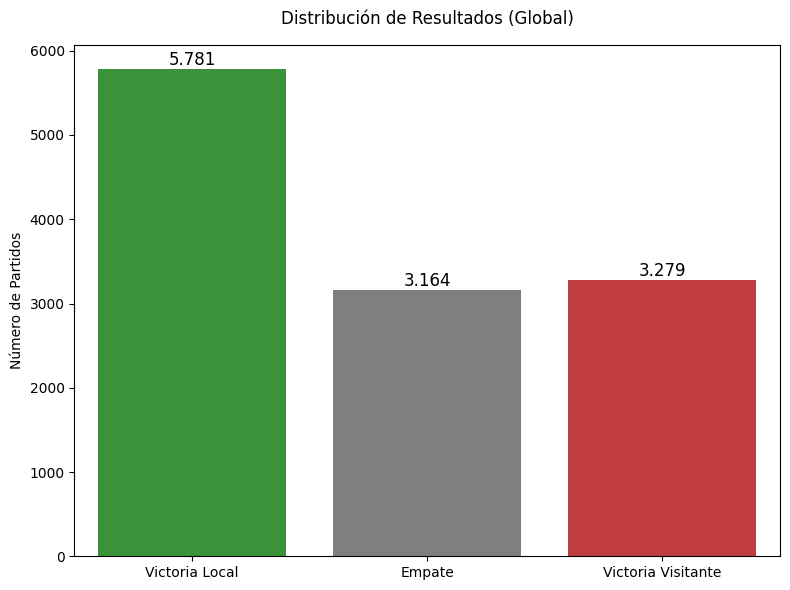

In [12]:
# Distribución de resultados (Global)
plt.figure(figsize=(8,6))
ax = sns.countplot(
    data=df,
    x='FTR',
    order=['H','D','A'],
    palette=['#2ca02c','#7f7f7f','#d62728']
)

# Renombrar etiquetas del eje x
ax.set_xticklabels(['Victoria Local', 'Empate', 'Victoria Visitante'])
ax.set_xlabel("")  # quitamos etiqueta genérica
ax.set_ylabel("Número de Partidos")
ax.set_title("Distribución de Resultados (Global)", pad=15)

# Anotar el valor encima de cada barra
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(
        f"{height:,}".replace(",", "."), # formatea con separador de miles
        (p.get_x() + p.get_width() / 2, height), # posición: centro x de la barra, y=altura
        ha='center', va='bottom',       # alineación
        fontsize=12
    )

plt.tight_layout()
plt.show()

El examen de la distribución global de resultados muestra un posible sesgo de jugar en casa y es que en el mundo del fútbol el equipo local siempre cuenta con cierta ventaja. De un total de 12 224 partidos que contiene el dataset:

- Victoria Local: 5.781 partidos (≈ 47,3 %)

- Empate: 3.164 partidos (≈ 25,9 %)

- Victoria Visitante: 3.279 partidos (≈ 26,8 %)

Esta desproporción confirma que casi la mitad de los encuentros acaban con triunfo del equipo local, mientras que los empates y las victorias visitantes se reparten por igual en torno al 26 % de los casos.

Estos resultados alertan sobre el desbalance de clases, la clase “Victoria Local” está sobrerrepresentada frente a las dos restantes. Quizás en etapas posteriores sea fundamental aplicar alguna técnica para asegurar que el modelo aprenda a distinguir correctamente también los empates y las victorias visitantes, sin dejarse llevar exclusivamente por el sesgo local.

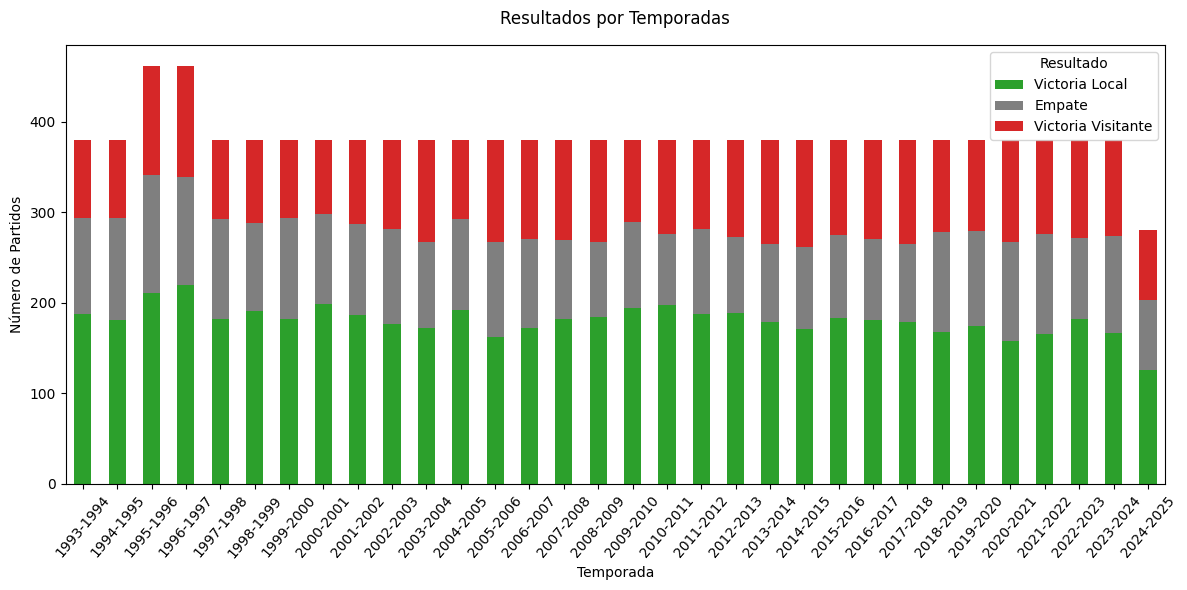

In [13]:
# Distribución de resultados por temporada
# Preparar los datos
season_counts = (
    df.groupby(['Season','FTR'])
      .size()
      .unstack(fill_value=0)
)

# Especificar el orden correcto: H, D, A
order = ['H','D','A']
colors = ['#2ca02c','#7f7f7f','#d62728']  # verde, gris, rojo

plt.figure(figsize=(12,6))
ax = season_counts[order].plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=plt.gca()
)

ax.set_title("Resultados por Temporadas", pad=15)
ax.set_xlabel("Temporada")
ax.set_ylabel("Número de Partidos")
ax.set_xticklabels(season_counts.index, rotation=50)

# Renombrar leyenda a textos completos
ax.legend(
    ['Victoria Local','Empate','Victoria Visitante'],
    title="Resultado"
)

plt.tight_layout()
plt.show()

Del anterior gráfico, se extraen la siguientes conclusiones:

1. **Predominio estable de la localía**. En todas las temporadas analizadas, las victorias locales (barras verdes) son la categoría mayoritaria, oscilando entre aproximadamente 160 y 220 partidos por campaña, lo que equivale a un 42–58 % de los encuentros.

2. **Variación puntual en los años noventa**. Las temporadas 1995–1996 y 1996–1997 exhiben un pico de triunfos en casa (más de 210), reflejo de una mayor cantidad de partidos en aquel periodo. A partir de 1998–1999, el número de victorias locales se estabiliza en torno a los 180–200 partidos.

3. **Empates relativamente constantes**. Los empates (barras grises) se mantienen en un rango estrecho de 90 a 120 partidos, sin tendencia ascendente o descendente clara. Esto indica que, a pesar de cambios en el estilo de juego o reglamentación, la proporción de empates se comporta de forma robusta a lo largo de las décadas.

4. **Leve incremento de triunfos visitantes**. Las victorias visitantes (barras rojas) crecen ligeramente desde los años noventa —donde rondaban los 140–150 partidos— hasta estabilizarse en 150–170 en las campañas más recientes, lo que sugiere un aumento gradual de la competitividad fuera de casa.

En conjunto, como ya vimos en el gráfico anterior estos hallazgos confirman la persistencia del “efecto local” como factor determinante, así como la necesidad de capturar en el modelo tanto la inercia del equipo anfitrión como las sutilezas que generan empates y triunfos foráneos. La estabilidad de las proporciones sugiere, además, de aplicar variables temporales recientes, estrategias de balanceo de clases para garantizar que el modelo aprenda a distinguir correctamente las tres categorías de resultado.

### 2. Distribución goles anotados

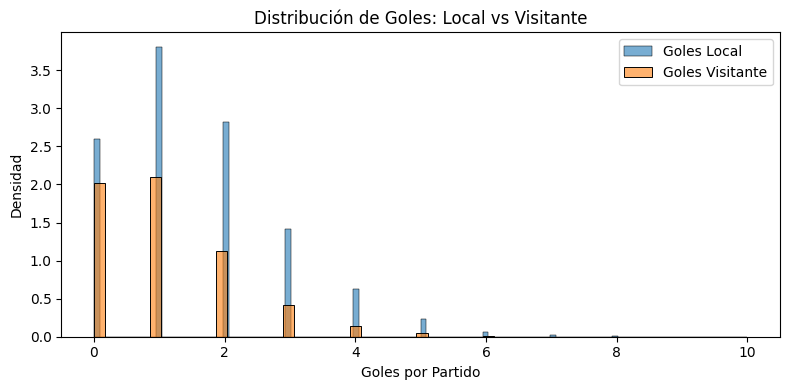

In [14]:
# Histograma / KDE de los goles que marcan los locales y los visitantes por partido.
plt.figure(figsize=(8,4))
sns.histplot(df['FTHG'], label='Goles Local', stat="density", color="#1f77b4", alpha=0.6)
sns.histplot(df['FTAG'], label='Goles Visitante', stat="density", color="#ff7f0e", alpha=0.6)
plt.title("Distribución de Goles: Local vs Visitante")
plt.xlabel("Goles por Partido")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()

Conclusiones del gráfico anterior:

1. **Patrón de anotación claramente sesgado**  
   - La mayor parte de los partidos acaba con 0–3 goles por equipo; en concreto, los encuentros con 1–2 goles locales son los más frecuentes, mientras que los visitantes marcan principalmente 0–1 gol.  
   - Esto pone de manifiesto que la capacidad goleadora en casa supera a la visitante de forma sistemática.

2. **“Ventaja de localía” a través de los goles**  
   - El hecho de que los locales anoten más goles contribuye directamente a la mayor proporción de victorias locales.  

3. **Baja incidencia de marcadores altos**  
   - Las barras para 4 o más goles son muy reducidas en ambos casos, lo que indica que los goleadas extremas aportan poca varianza al dataset.  

En conjunto, el histograma confirma que la diferencia en la distribución de goles es un factor clave para explicar la ventaja local que hay en el dataset y en el mundo del fútbol, pero para nuestro caso que queremos predecir si un partido finaliza con victoria local, empate o victoria visitante, no es necesario utilizar este patrón de anotación.


### 3. Número de partidos por equipo

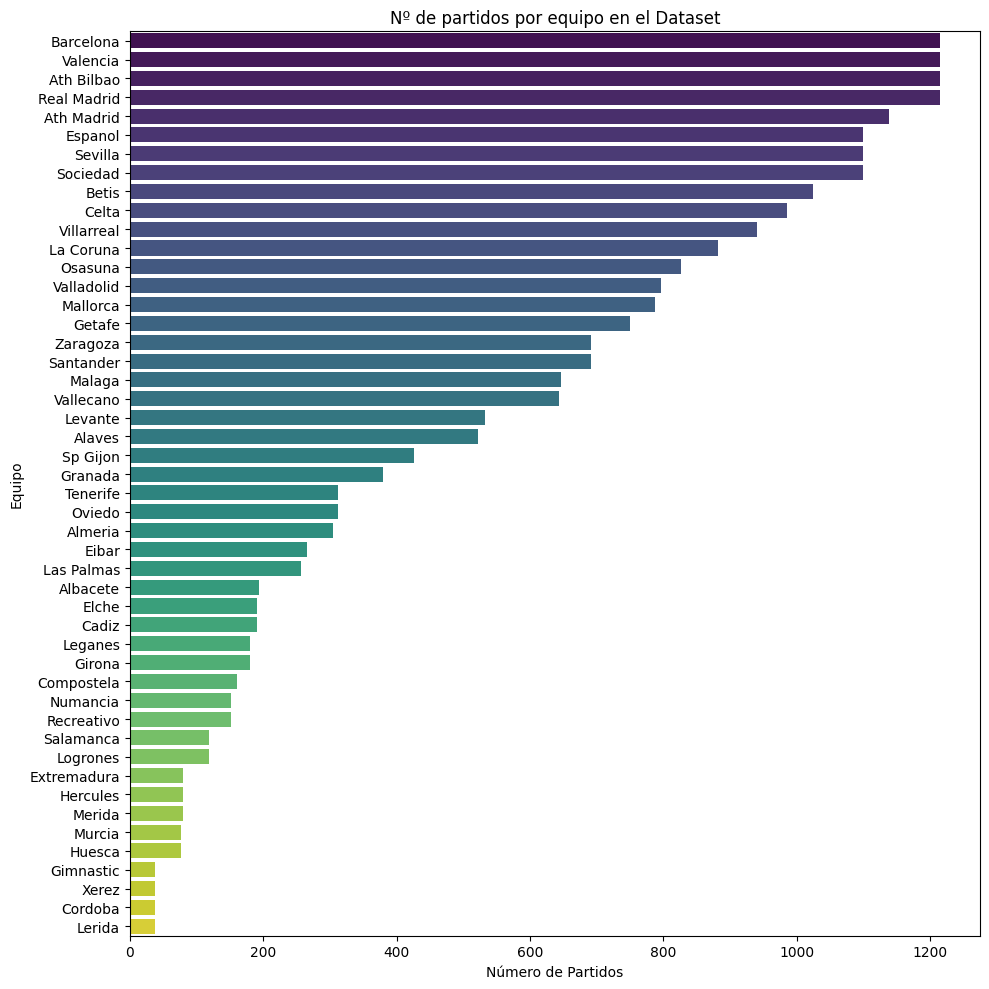

In [15]:
# Número de partidos por equipo
partidos_por_equipo = pd.concat([df['HomeTeam'], df['AwayTeam']]).value_counts()
top10 = partidos_por_equipo.nlargest(10)
plt.figure(figsize=(10,10))
sns.barplot(x=partidos_por_equipo.values, y=partidos_por_equipo.index, palette="viridis")
plt.title("Nº de partidos por equipo en el Dataset")
plt.xlabel("Número de Partidos")
plt.ylabel("Equipo")
plt.tight_layout()
plt.show()

En el gráfico anterior vemos que:

1. **Participación desigual en LaLiga**. El gráfico muestra que un puñado de equipos —Barcelona, Valencia, Athletic de Bilbao, Real Madrid y Atlético de Madrid— acumulan más de 1 200 partidos en el histórico analizado, lo que equivale aproximadamente a haber disputado todas las jornadas de las últimas 30 temporadas. En el extremo contrario, clubes como Lérida, Córdoba o Xerez registran menos de 100 encuentros, pues han alternado ascensos y descensos a otros niveles.

2. **No confundir volumen con éxito**. Aunque estos cinco “fijos” en Primera División poseen el mayor número de partidos, ello no implica que tengan las tasas de victoria más elevadas. Existen equipos con menor presencia histórica que, en sus periodos de permanencia, han logrado ratios de victoria comparables o incluso superiores.

3. **Importancia de la forma reciente**. Dado que el volumen de datos por equipo varía significativamente, un modelo que se apoye únicamente en estadísticas agregadas a largo plazo podría sobreponderar a los clubes con más historia en Primera. Por ello, es esencial incorporar **features de forma reciente** para capturar la dinámica actual de cada equipo, independientemente de cuántos partidos haya jugado en total.

En definitiva, la mera frecuencia de aparición en Primera División es un indicador de estabilidad institucional, pero no explica por sí misma la probabilidad de victoria en un partido concreto; la clave estará en combinar dicha trayectoria con la “forma” más inmediata de cada equipo.

### 4. Resultados por equipo.

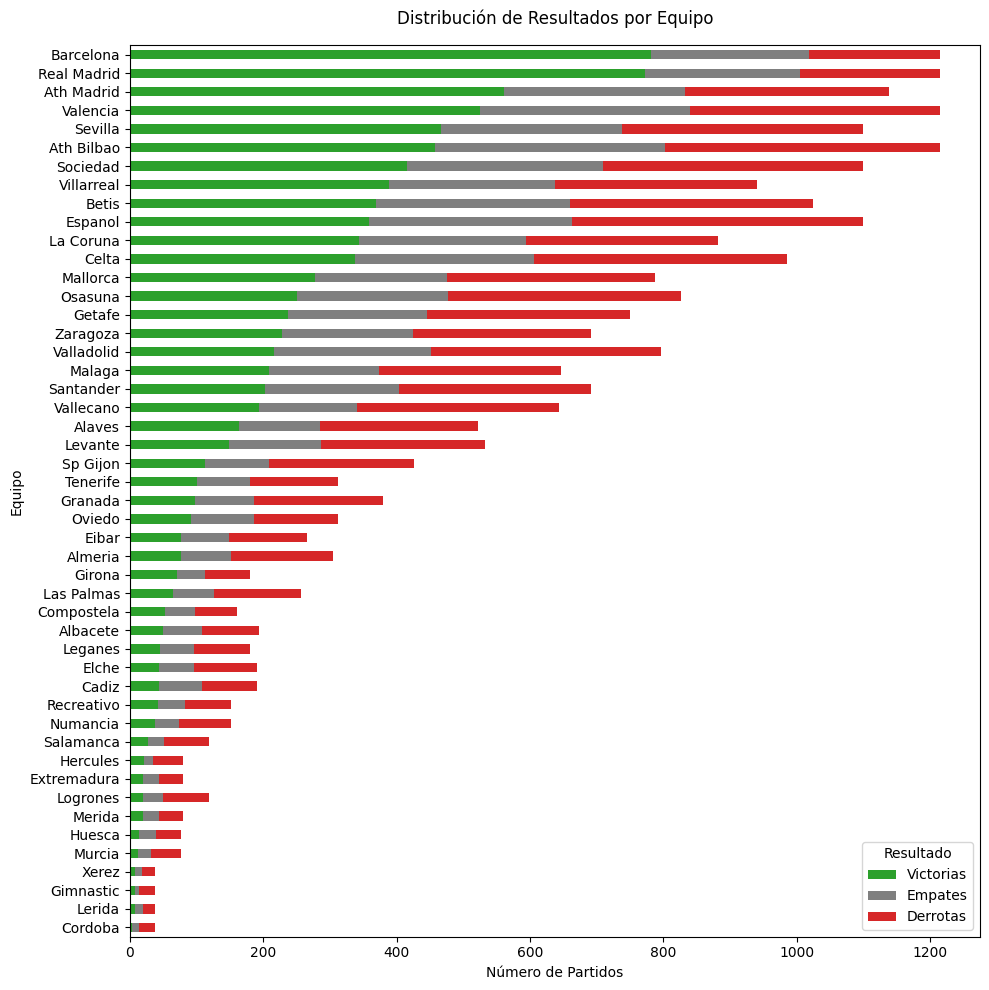

In [16]:
# Número de victorias, empates y derrotas de cada equipo.
results = []
for team in df['HomeTeam'].unique():
    sub = df[(df['HomeTeam']==team) | (df['AwayTeam']==team)]
    wins = ((sub['HomeTeam']==team)&(sub['FTR']=='H') | (sub['AwayTeam']==team)&(sub['FTR']=='A')).sum()
    draws = (sub['FTR']=='D').sum()
    losses = len(sub) - wins - draws
    results.append({'Team': team, 'Wins': wins, 'Draws': draws, 'Losses': losses})

res_df = pd.DataFrame(results).set_index('Team')

# Seleccionar todos los equipo
res_top48 = res_df.nlargest(48, 'Wins')

# Dibujar barh apilado
plt.figure(figsize=(10, 10))
ax = res_top48.plot(
    kind='barh',
    stacked=True,
    color=['#2ca02c','#7f7f7f','#d62728'],  # verde=Wins, gris=Draws, rojo=Losses
    ax=plt.gca()
)

# Invertir eje y para que el equipo con más Wins quede arriba
ax.invert_yaxis()

# Etiquetas, título y leyenda ---
ax.set_title("Distribución de Resultados por Equipo", pad=15)
ax.set_xlabel("Número de Partidos")
ax.set_ylabel("Equipo")

ax.legend(
    ['Victorias', 'Empates', 'Derrotas'],
    title="Resultado",
    loc='lower right'
)

plt.tight_layout()
plt.show()

Este gráfico muestra, para los 48 equipos que actualmente existen en el dataset, la distribución absoluta de triunfos (verde), empates (gris) y derrotas (rojo). A continuación se extraen los principales hallazgos:

1. **Volumen de partidos vs. victorias absolutas**  
   - Equipos como **Barcelona y Real Madrid** lideran en número total de encuentros disputados (alrededor de 1 200), con **750-800 victorias**, **200-250 empates** y **200–250 derrotas** aproximadamente cada uno.  
   - Esa gran cantidad de partidos jugados no debe confundirse con una tasa de éxito (p. ej., porcentaje de victorias), que es el indicador más representativo de su fortaleza histórica.

2. **Tasas de victoria destacadas**  
   - La proporción de triunfos para estos dos grandes oscila entre el **60%** y el **65%**, un nivel muy alto en un campeonato competitivo y es por ello que normalmente siempre pelean por los puestos de arriba.  
   - En contraste, clubes con menos participaciones (por ejemplo, **Leganés** o **Girona**) que actualmente se encuentran en Primera División, acumulan entre **150–200 partidos** y para este último **60–80 triunfos**, lo que se traduce en tasas de victoria cerca del 40%.

3. **Empates y derrotas como equilibrio**  
   - El bloque medio (Valencia, Sevilla, Athletic, Real Sociedad, Villarreal, Betis…) muestra un reparto más equilibrado entre victorias, empates (≈300) y derrotas (≈300–400), reflejando ligas con mayor variabilidad. Y son estos mismos equipos los que según la temporada están mas arriba o mas abajo en la tabla de clasificación.  
   - Los equipos de menor trayectoria histórica presentan un segmento de derrotas muy superior al de victorias, indicando dificultades de adaptación al nivel de Primera.

4. **Implicaciones para la modelización**  
   - Las **estadísticas absolutas** (total de victorias, empates y derrotas) ayudan a entender la experiencia histórica de cada club, pero **no** bastan para predecir un partido concreto.  
   - Resulta esencial normalizar estas métricas en **ratios** (victorias/partidos totales, puntos por partido) y combinarlas con **features de forma reciente** (racha de últimos encuentros) para captar la dinámica actual y evitar el sesgo hacia los equipos “históricos”.

En resumen, el gráfico subraya la necesidad de integrar tanto la **trayectoria acumulada** como la **dinámica reciente** de cada equipo en el sistema predictivo, usando variables normalizadas que permitan comparar de forma justa a clubes con distinto número de participaciones en Primera División.

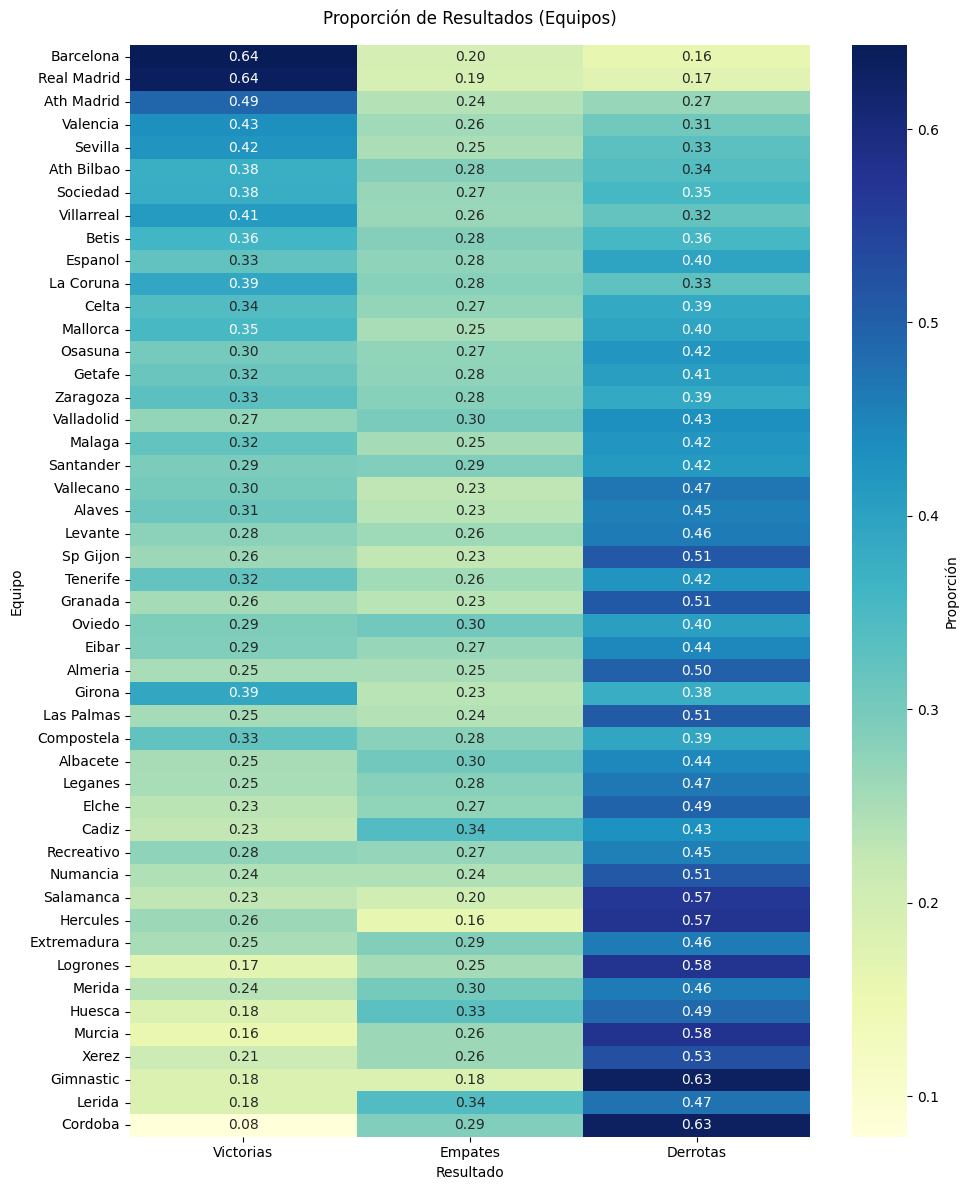

In [17]:
# Heatmap de proporciones (Victorias, Empates, Derrotas) de los equipos de la liga de fútbol 
# Calculamos proporciones por fila
prop = res_top48.div(res_top48.sum(axis=1), axis=0)

# Dibujamos el heatmap
plt.figure(figsize=(10, 12))
ax = sns.heatmap(
    prop,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Proporción'}
)

# Ajustes de ejes y título
ax.set_title("Proporción de Resultados (Equipos)", pad=15)
ax.set_xlabel("Resultado")
ax.set_ylabel("Equipo")

# Renombrar columnas en el eje x
ax.set_xticklabels(['Victorias', 'Empates', 'Derrotas'], rotation=0)

plt.tight_layout()
plt.show()

Del gráfico anterior deducimos lo siguiente:

1. **Segmentación clara entre grandes y pequeños**  
   - **Barcelona y Real Madrid** se distinguen con una proporción de victorias de aproximadamente el **64%**, la más alta de todas, y pérdidas inferiores al **17%**.  
   - En el otro extremo, equipos con escasa trayectoria en Primera—como **Córdoba** y **Lérida**—presentan tasas de victoria muy bajas (8–18 %) y derrotas muy elevadas (63–63 %), reflejando su dificultad para competir al máximo nivel también debido a que solo han disputado una temporada en Primera División.

2. **Bloque intermedio equilibrado**  
   - La mayoría de los equipos históricos (Ath Madrid, Valencia, Sevilla, Athletic, Real Sociedad) exhiben una proporción de victorias en torno al **40%**, empates en el **25–30%** y derrotas en el **30–35%**.  
   - Esta distribución muestra ligas con alta competitividad, donde ni la victoria ni la derrota dominan de forma absoluta.

3. **Importancia de los empates como variable predictiva**  
   - Algo si destacable es que los empates oscilan en un rango relativamente estrecho (20–35 %) para casi todos los equipos, lo que sugiere que modelar correctamente esta clase requerirá identificar factores que reducen la probabilidad de victoria de ambos bandos, más allá de la ventaja de localía.

4. **Implicaciones para el modelo**  
   - Las proporciones normalizadas de resultados ofrecen una visión más justa que los conteos absolutos: un equipo con menos partidos puede tener una tasa de victorias comparable a otro con mayor historia.  
   - Es recomendable incluir en el modelo features derivadas de estas proporciones (victorias/puntos por partido, porcentaje de empates) y combinarlas con métricas de forma reciente para capturar tanto la solvencia histórica como la dinámica actual de cada club.

En conjunto, el heatmap pone de manifiesto tres “grupos” de rendimiento en LaLiga: poderosos dominadores con altísimas tasas de victoria, un bloque medio muy competitivo y una categoría de clubes con baja eficacia histórica. Estas distinciones aconsejan emplear variables normalizadas y contextualizadas temporalmente para predecir de forma equilibrada los resultados (H/D/A).

### 5. Clasificación histórica. 

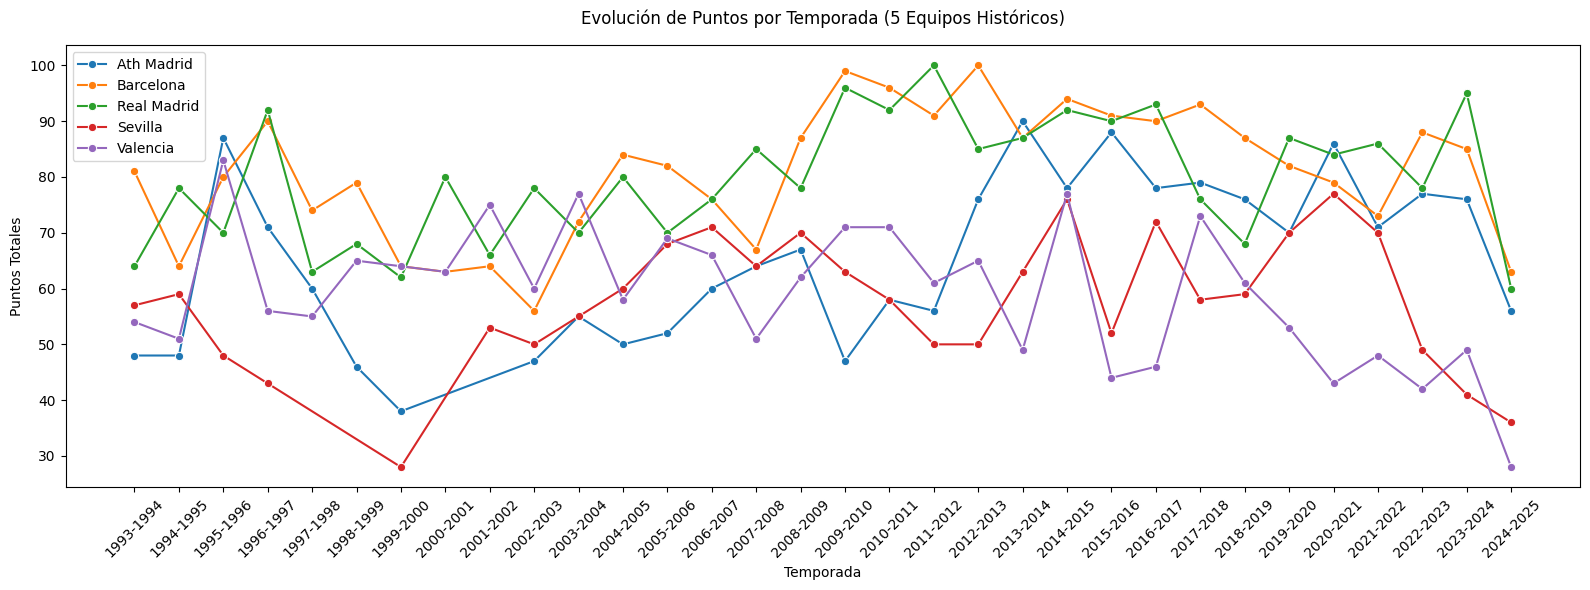

In [18]:
# Gráfico de evolución de puntos (y posición) de todos los equipos a lo largo de las temporadas.

home_points = (
    df[['Season', 'HomeTeam', 'FTR']]
    .assign(Points=lambda d: d['FTR'].map({'H': 3, 'D': 1, 'A': 0}))
    .rename(columns={'HomeTeam': 'Team'})
    [['Season', 'Team', 'Points']]
)

away_points = (
    df[['Season', 'AwayTeam', 'FTR']]
    .assign(Points=lambda d: d['FTR'].map({'H': 0, 'D': 1, 'A': 3}))
    .rename(columns={'AwayTeam': 'Team'})
    [['Season', 'Team', 'Points']]
)

# Concatenamos y agrupamos
points = (
    pd.concat([home_points, away_points], ignore_index=True)
      .groupby(['Season', 'Team'], as_index=False)['Points']
      .sum()
)

# Seleccionamos los 5 equipos históricos que queremos comparar
equipos_hist = ['Real Madrid', 'Barcelona', 'Ath Madrid', 'Valencia', 'Sevilla']
hist5 = points[points['Team'].isin(equipos_hist)]

# Dibujamos la evolución de puntos por temporada
plt.figure(figsize=(16, 6))
sns.lineplot(
    data=hist5,
    x='Season',
    y='Points',
    hue='Team',
    marker="o"
)

plt.title("Evolución de Puntos por Temporada (5 Equipos Históricos)", pad=15)
plt.xlabel("Temporada")
plt.ylabel("Puntos Totales")
plt.xticks(rotation=45)
plt.legend(title="")
plt.tight_layout()
plt.show()

Del gráfico de evolución anteriores deducimos que:

1. **Dominio sostenido de Barcelona y Real Madrid**. Ambos clubes mantienen sistemáticamente las cifras más altas de la competición, rondando los **80–100 puntos** por temporada desde mediados de los años 90.  

2. **Ascenso de Atlético de Madrid**. Tras un periodo más modesto en los 90 (excepto en la temporada 1995/96) y primeros 2000 (≈40–55 pts), Atlético muestra una **curva ascendente a partir de 2006–07**, llegando a rondar los **90 puntos en 2013–14 y 2015–16**. Este crecimiento coincide con inversiones y un nuevo proyecto deportivo, situándolo como tercer gran dominador de la liga desde hace bastantes años.

3. **Valencia en regresión**. Un histórico como el Valencia obtuvo buenos resultados en **1996–97 (≈83 pts) y 2003–04 (≈77 pts)**, pero tras 2007–08 (≈65 pts) inicia una **tendencia descendente**, estabilizándose por debajo de **60 puntos** en las últimas temporadas, lo que evidencia problemas de competitividad y cambios institucionales.

4. **Sevilla, crecimiento y estabilización**. Sevilla parte de una posición baja en 1999–00 (≈28 pts) pero experimenta un **salto de rendimiento desde mediados de los 2000**, consiguiendo sus mayores éxitos y alcanzando su máximo histórico en **2014–15 (≈77 pts)**. Posteriormente se mantiene en un rango de **50–70 puntos**, consolidándose como un club de media-alta tabla aunque estas últimas temporadas su rendimiento también ha bajado.

5. **Implicaciones para la predicción**  
   - La **consistencia** de Barcelona y Real Madrid justifica asignarles un mayor **valor base** en el modelo.  
   - Sin embargo, la **dinámica ascendente** de Atlético de Madrid y la **caída** de Valencia subrayan la necesidad de dar peso a **features de forma reciente** (puntos en las últimas jornadas) para captar cambios de ciclo y ajustar las probabilidades de cada equipo en cada temporada, evitando depender solo del desempeño histórico agregado.

En conjunto, estos patrones confirman que, además de la trayectoria acumulada, la **evolución temporal** de cada club—especialmente sus picos y valles de puntuación—debe integrarse en el sistema predictivo para reflejar la realidad cambiante de LaLiga.

## Conclusiones Generales del Análisis Exploratorio de Datos  

Tras estudiar las distribuciones de resultados, goles, participación histórica y evolución de puntos de los equipos, podemos extraer los siguientes aprendizajes clave para orientar el diseño del modelo predictivo:

1. **Ventaja de la localía muy pronunciada**  
   - Aproximadamente la mitad de los encuentros terminan con victoria del equipo local, frente a un 25 % de empates y un 25 % de triunfos visitantes, proporción que se repite de forma estable a lo largo de tres décadas.  
   - Este sesgo deberá incorporarse explícitamente al modelo.

2. **Distribuciones de goles concentradas en bajas anotaciones**  
   - Casi el 90 % de los partidos presentan 0–3 goles por equipo, con los locales más proclives a marcar 1–2 tantos y los visitantes a 0–1.  
   - Las goleadas extremas son muy raras.
   - No vamos a tener en cuenta los goles para el modelo debido a que no queremos predecir resultado de goles, por lo que las features de goles no se incluirán en el modelo.

3. **Desigualdad histórica entre clubes**  
   - Solo cuatro o cinco equipos han disputado prácticamente todas las temporadas, mientras que otros han irrumpido de forma intermitente.  
   - Sin embargo, el **número absoluto** de victorias no refleja completamente el nivel de un club: es imprescindible trabajar con **ratios** (victorias/partidos, puntos por encuentro) y con **métricas de racha** (puntos en las últimas 5–10 jornadas) para evitar sesgos de volumen histórico.

4. **Evolución de la competitividad**  
   - Barcelona y Real Madrid dominan el palmarés y la puntuación año tras año, pero en la última década Atlético de Madrid y Sevilla han ido escalando posiciones de forma notable.  
   - El modelo debe calibrarse para captar estos ciclos: un recién ascendido o un club en racha puede superar a un equipo "superior" en determinados tramos de temporada.

5. **Implicaciones para el modelado**  
   - **Features históricas**: proporción de victorias/empates/derrotas a lo largo de series temporales.  
   - **Features recientes**: racha de los últimos 5–10 partidos en casa o fuera, rendimiento en enfrentamientos directos de los últimos años.  
   - **Balance de clases**: dada la preponderancia de la localía y la escasa frecuencia de empates, será recomendable aplicar técnicas de ponderación o sobremuestreo/undersampling en la etapa de entrenamiento.

En conjunto, este EDA confirma la necesidad de un enfoque dual que combine la **solidez de las estadísticas históricas** con la **agilidad de las métricas de forma reciente**, garantizando así un sistema predictivo capaz de adaptarse tanto a la inercia de cada club como a sus cambios de ciclo en la competición.

# Ingeniería de Características

A continuación crearemos las variables que incorporan la **ponderación temporal**:
1. **Forma reciente (últimos 5 partidos):** Para cada equipo, se calcula:
   - Puntos acumulados (3 ptos por victoria, 1 por empate y 0 por derrota)

2. **Enfrentamientos directos (últimos 3 años):** Para cada partido, se extraen estadísticas de partidos previos entre los dos equipos (número de victorias, empates y diferencia de goles) en un lapso de 3 años.

3. **Rendimiento histórico a largo plazo (últimos 5 años):** Se estima el promedio de puntos por partido de cada equipo en los últimos 5 años.

Implementaremos funciones auxiliares para calcular estas métricas de forma “on the fly” para cada partido (usando solamente los partidos anteriores a la fecha del encuentro para evitar fuga de datos).


In [19]:
# Función para calcular los puntos conseguidos en un partido para un equipo
def compute_points(row, team):
    # Si equipo local
    if row['HomeTeam'] == team:
        if row['FTR'] == 'H':
            return 3
        elif row['FTR'] == 'D':
            return 1
        else:
            return 0
    # Si equipo visitante
    else:
        if row['FTR'] == 'A':
            return 3
        elif row['FTR'] == 'D':
            return 1
        else:
            return 0
        
# Función para obtener las estadísticas de racha reciente de un equipo (últimos n partidos)
def get_team_recent_stats(team, current_date, df, n=5):
    # Filtrar partidos en los que el equipo participó antes de la fecha actual
    team_matches = df[(df['Date'] < current_date) & ((df['HomeTeam'] == team) | (df['AwayTeam'] == team))]
    team_matches = team_matches.sort_values('Date')
    if team_matches.empty:
        return 0
    
    recent_matches = team_matches.tail(n)
    points = recent_matches.apply(lambda row: compute_points(row, team), axis=1).sum()
    return points

# Función para calcular estadísticas de enfrentamientos directos entre dos equipos en los últimos 3 años
def get_head2head_stats(team_home, team_away, current_date, df, years=3):
    cutoff_date = current_date - pd.DateOffset(years=years)
    
    # Filtrar partidos entre los dos equipos en los últimos 3 años
    head2head = df[(df['Date'] >= cutoff_date) & (df['Date'] < current_date) &
                   (((df['HomeTeam'] == team_home) & (df['AwayTeam'] == team_away)) |
                    ((df['HomeTeam'] == team_away) & (df['AwayTeam'] == team_home)))]
    
    home_wins = 0
    draws = 0
    away_wins = 0
    for _, row in head2head.iterrows():
        if row['HomeTeam'] == team_home:
            # El partido se jugó en casa para team_home
            if row['FTR'] == 'H':
                home_wins += 1
            elif row['FTR'] == 'D':
                draws += 1
            else:
                away_wins += 1
        else:
            # team_home era visitante en el encuentro
            if row['FTR'] == 'A':
                home_wins += 1
            elif row['FTR'] == 'D':
                draws += 1
            else:
                away_wins += 1
            
    return home_wins, draws, away_wins
    
# Función para calcular el rendimiento histórico a largo plazo (promedio de puntos en los últimos 5 años)
def get_team_longterm_avg(team, current_date, df, years=5):
    cutoff_date = current_date - pd.DateOffset(years=years)
    
    # Filtrar partidos en los que el equipo participó en los últimos 5 años
    team_matches = df[(df['Date'] >= cutoff_date) & (df['Date'] < current_date) & ((df['HomeTeam'] == team) | (df['AwayTeam'] == team))]
    
    if team_matches.empty:
        return 0
    
    total_points = team_matches.apply(lambda row: compute_points(row, team), axis=1).sum()
    matches_played = len(team_matches)
    
    return total_points / matches_played

## Creación de Variables de Características

Ahora crearemos, para cada partido, nuevas columnas que contengan:
- `Home_Last5_Points`
- `Away_Last5_Points`
- Estadísticas de head-to-head: `H2H_HomeWins_3yr`, `H2H_Draws_3yr`, `H2H_AwayWins_3yr`
- Rendimiento a largo plazo: `Home_LongTerm_AvgPoints` y `Away_LongTerm_AvgPoints`

Se utilizará la información únicamente de partidos anteriores a la fecha actual para evitar fugas de información.


In [20]:
# Inicializamos las nuevas columnas del dataframe con sus valores por defecto
df['Home_Last5_Points'] = 0
df['Away_Last5_Points'] = 0

df['H2H_HomeWins_3yr'] = 0
df['H2H_Draws_3yr'] = 0
df['H2H_AwayWins_3yr'] = 0

df['Home_LongTerm_AvgPoints'] = 0.0
df['Away_LongTerm_AvgPoints'] = 0.0

# Iteramos por cada partido
for idx, row in df.iterrows():
    current_date = row['Date']
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    # Forma reciente del equipo local
    home_points = get_team_recent_stats(home_team, current_date, df)
    df.at[idx, 'Home_Last5_Points'] = home_points
    
    # Forma reciente del equipo visitante
    away_points= get_team_recent_stats(away_team, current_date, df)
    df.at[idx, 'Away_Last5_Points'] = away_points
    
    # Estadísticas de enfrentamientos directos en los últimos 3 años
    home_wins, draws, away_wins = get_head2head_stats(home_team, away_team, current_date, df, years=3)
    df.at[idx, 'H2H_HomeWins_3yr'] = home_wins
    df.at[idx, 'H2H_Draws_3yr'] = draws
    df.at[idx, 'H2H_AwayWins_3yr'] = away_wins
    
    # Rendimiento histórico a largo plazo (últimos 5 años) para cada equipo
    df.at[idx, 'Home_LongTerm_AvgPoints'] = get_team_longterm_avg(home_team, current_date, df, years=5)
    df.at[idx, 'Away_LongTerm_AvgPoints'] = get_team_longterm_avg(away_team, current_date, df, years=5) 
    
df   

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,Home_Last5_Points,Away_Last5_Points,H2H_HomeWins_3yr,H2H_Draws_3yr,H2H_AwayWins_3yr,Home_LongTerm_AvgPoints,Away_LongTerm_AvgPoints
0,1993-09-05,Barcelona,Sociedad,3.0,0.0,H,1993-1994,0,0,0,0,0,0.000000,0.000000
1,1993-09-05,Ath Bilbao,Albacete,4.0,1.0,H,1993-1994,0,0,0,0,0,0.000000,0.000000
2,1993-09-05,Zaragoza,Sevilla,1.0,2.0,A,1993-1994,0,0,0,0,0,0.000000,0.000000
3,1993-09-05,Valladolid,Sp Gijon,0.0,1.0,A,1993-1994,0,0,0,0,0,0.000000,0.000000
4,1993-09-05,Tenerife,Lerida,1.0,0.0,H,1993-1994,0,0,0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12218,2025-03-16,Sevilla,Ath Bilbao,0.0,1.0,A,2024-2025,8,8,2,2,2,1.557895,1.489474
12219,2025-03-16,Osasuna,Getafe,1.0,2.0,A,2024-2025,6,9,1,2,3,1.269841,1.068421
12220,2025-03-16,Vallecano,Sociedad,2.0,2.0,D,2024-2025,4,6,1,3,2,1.170213,1.573684
12221,2025-03-16,Ath Madrid,Barcelona,2.0,4.0,A,2024-2025,8,15,1,0,4,2.057895,2.148148


# Preprocesamiento de Features y Target

Prepararemos las variables features y el target (resultado) a predecir.  

Mapearemos la columna `FTR` a valores numéricos:
- 1 → Victoria local  
- 0 → Empate  
- 2 → Victoria visitante  

Además, añadiremos variables categóricas a partir de los nombres de los equipos (usando one-hot encoding) para que el modelo reconozca la identidad de cada club.

In [21]:
# Mapeo del resultado final a valores numéricos
result_maping = {'H': 1, 'D': 0, 'A': 2}
df['Result'] = df['FTR'].map(result_maping)

# Seleccionamos las variables de entrada (features) que se usarán para el modelo
features = ['Home_Last5_Points', 'Away_Last5_Points', 'H2H_HomeWins_3yr', 'H2H_Draws_3yr', 'H2H_AwayWins_3yr', 'Home_LongTerm_AvgPoints', 'Away_LongTerm_AvgPoints']

# Agregar variables categoricas. One-hot encoding para HomeTeam y AwayTeam
df_features = pd.get_dummies(df, columns=['HomeTeam', 'AwayTeam'])

# Actualizamos la lista de features con las nuevas columnas generadas para los equipos.
# Se asume que todas las columnas que empiezan por "HomeTeam_" y "AwayTeam_" deben incluirse.
cat_features = [col for col in df_features.columns if col.startswith('HomeTeam_') or col.startswith('AwayTeam_')]
features.extend(cat_features)

# Nuestro target es la columna "Result"
target = 'Result'

print("Número total de features:", len(features))
print("Features seleccionadas:", features)

df_features

Número total de features: 103
Features seleccionadas: ['Home_Last5_Points', 'Away_Last5_Points', 'H2H_HomeWins_3yr', 'H2H_Draws_3yr', 'H2H_AwayWins_3yr', 'Home_LongTerm_AvgPoints', 'Away_LongTerm_AvgPoints', 'HomeTeam_Alaves', 'HomeTeam_Albacete', 'HomeTeam_Almeria', 'HomeTeam_Ath Bilbao', 'HomeTeam_Ath Madrid', 'HomeTeam_Barcelona', 'HomeTeam_Betis', 'HomeTeam_Cadiz', 'HomeTeam_Celta', 'HomeTeam_Compostela', 'HomeTeam_Cordoba', 'HomeTeam_Eibar', 'HomeTeam_Elche', 'HomeTeam_Espanol', 'HomeTeam_Extremadura', 'HomeTeam_Getafe', 'HomeTeam_Gimnastic', 'HomeTeam_Girona', 'HomeTeam_Granada', 'HomeTeam_Hercules', 'HomeTeam_Huesca', 'HomeTeam_La Coruna', 'HomeTeam_Las Palmas', 'HomeTeam_Leganes', 'HomeTeam_Lerida', 'HomeTeam_Levante', 'HomeTeam_Logrones', 'HomeTeam_Malaga', 'HomeTeam_Mallorca', 'HomeTeam_Merida', 'HomeTeam_Murcia', 'HomeTeam_Numancia', 'HomeTeam_Osasuna', 'HomeTeam_Oviedo', 'HomeTeam_Real Madrid', 'HomeTeam_Recreativo', 'HomeTeam_Salamanca', 'HomeTeam_Santander', 'HomeTeam_Sev

,Date,FTHG,FTAG,FTR,Season,Home_Last5_Points,Away_Last5_Points,H2H_HomeWins_3yr,H2H_Draws_3yr,H2H_AwayWins_3yr,...,AwayTeam_Sevilla,AwayTeam_Sociedad,AwayTeam_Sp Gijon,AwayTeam_Tenerife,AwayTeam_Valencia,AwayTeam_Valladolid,AwayTeam_Vallecano,AwayTeam_Villarreal,AwayTeam_Xerez,AwayTeam_Zaragoza
0,1993-09-05,3.0,0.0,H,1993-1994,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,False
1,1993-09-05,4.0,1.0,H,1993-1994,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,1993-09-05,1.0,2.0,A,1993-1994,0,0,0,0,0,...,True,False,False,False,False,False,False,False,False,False
3,1993-09-05,0.0,1.0,A,1993-1994,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,False
4,1993-09-05,1.0,0.0,H,1993-1994,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12218,2025-03-16,0.0,1.0,A,2024-2025,8,8,2,2,2,...,False,False,False,False,False,False,False,False,False,False
12219,2025-03-16,1.0,2.0,A,2024-2025,6,9,1,2,3,...,False,False,False,False,False,False,False,False,False,False
12220,2025-03-16,2.0,2.0,D,2024-2025,4,6,1,3,2,...,False,True,False,False,False,False,False,False,False,False
12221,2025-03-16,2.0,4.0,A,2024-2025,8,15,1,0,4,...,False,False,False,False,False,False,False,False,False,False


# División del Dataset: Conjunto de Entrenamiento y Prueba

Dado que se trata de datos de series temporales, se realiza una división *temporal* para evitar que datos futuros influyan en el entrenamiento. Vamos a utilizar un 80% de los datos (anteriores) para entrenar y el 20% restante (más recientes) para pruebas.  
Esta división simula la situación real de predecir partidos futuros.

In [22]:
# Usaremos la fecha para separar los datos de entrenamiento y test. Para ser mas realista los partidos mas recientes para test. 
# Por simplicidad usaremos el percentil 80 de la fecha.
date_threshold = df_features['Date'].quantile(0.8)
train_df = df_features[df_features['Date'] < date_threshold].copy()
test_df = df_features[df_features['Date'] >= date_threshold].copy()

print("Cantidad de partidos de entrenamiento: ", len(train_df))
print("Cantidad de partidos de test: ", len(test_df))

# Extraemos las matrices X e y
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

print("División de resultados set de entrenamiento:", y_train.value_counts(), "\n")
print("División de resultados set de test:", y_test.value_counts())

Cantidad de partidos de entrenamiento:  9779
Cantidad de partidos de test:  2445
División de resultados set de entrenamiento: Result
1    4683
2    2601
0    2495
Name: count, dtype: int64 

División de resultados set de test: Result
1    1098
2     678
0     669
Name: count, dtype: int64


# Entrenamiento del Modelo. 

# 1. XGBoost

El primer modelo a utilizar será **XGBoost**, un algoritmo de clasificación que se utiliza en muchos proyectos de ML.
Configura­mos parámetros iniciales y se usa una búsqueda de hiperparámetros (GridSearchCV) para afinar algunos hiperparámetros importantes.

Una vez entrenado el modelo, evaluamos su desempeño en el conjunto de prueba:  
- Se calculará la exactitud (accuracy)  
- Se mostrará el **classification report**  
- Se generará y visualizará la matriz de confusión

Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mejor score: 0.5049099836333878
Accuracy XGBoost: 50.92%

Reporte de clasificación:
               precision    recall  f1-score   support

   D (Empate)       0.14      0.00      0.00       669
    H (Local)       0.51      0.91      0.65      1098
A (Visitante)       0.53      0.37      0.43       678

     accuracy                           0.51      2445
    macro avg       0.39      0.43      0.36      2445
 weighted avg       0.41      0.51      0.41      2445



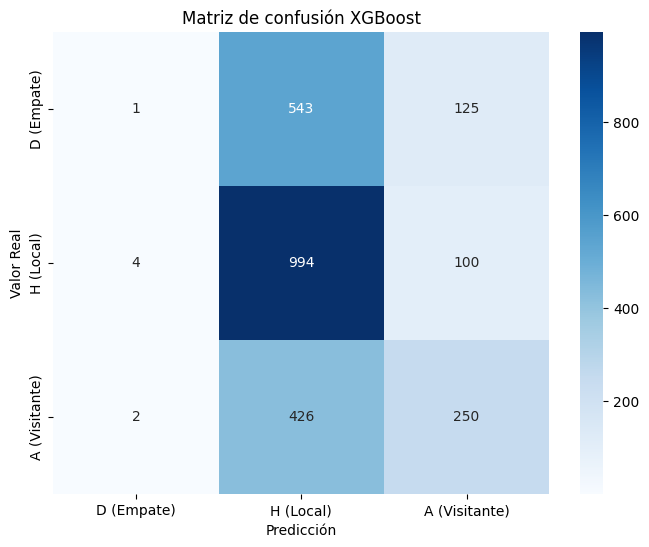

In [23]:
# Definimos el clasificador XGBoost
model = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
                                       #softmax
# Parámetros de búsqueda
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Utilizamos TimeSeriesSplit para evitar mezclar datos pasados y futuros
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score:", grid.best_score_)

# Entrenar el modelo final con los mejores hiperparámetros
best_model = grid.best_estimator_

# Predicciones en el conjunto de test
y_pred = best_model.predict(X_test)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy XGBoost: {:.2f}%".format(accuracy * 100))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['D (Empate)', 'H (Local)', 'A (Visitante)']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['D (Empate)', 'H (Local)', 'A (Visitante)'], yticklabels=['D (Empate)', 'H (Local)', 'A (Visitante)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de confusión XGBoost')
plt.show()

**Análisis de los Resultados Obtenidos con XGBoost**  

1. **Precisión global**  
   El clasificador XGBoost logra una **accuracy entorno al 51%**, igualando el comportamiento de un clasificador “siempre local” (≈51 %), pero todavía lejos de un rendimiento equilibrado.

2. **Desbalance de clases**  
   - **Empates (D):** precision = 0,14 pero recall = 0,00 (f1-score = 0,00). De los 669 empates reales, sólo **1** se predice correctamente, mientras **668** se interpretan erróneamente como triunfo local o visitante.  
   - **Victorias locales (H):** recall = 0,91 y precision = 0,51 (f1-score = 0,65). El modelo reconoce la mayoría de las victorias en casa, aunque confunde con “H” muchos empates y partidos visitantes.  
   - **Victorias visitantes (A):** recall = 0,37 y precision = 0,53 (f1-score = 0,43), mostrando cierta capacidad para detectar triunfos fuera, pero aún con un sesgo hacia la localía.

3. **Matriz de confusión**  
   - **Empates:** 1 clasificación correcta (“D”) frente a 543 como “H” y 125 como “A”.  
   - **Locales:** de 1098 encuentros, 994 se etiquetan correctamente y 100 como “A”.  
   - **Visitantes:** de 678 partidos, 250 se capturan bien como “A” y 426 se asignan erróneamente a “H”.

4. **Interpretación**  
   XGBoost presenta un sesgo marcado hacia la clase “Victoria Local”, ignorando casi por completo la categoría “Empate” y, en menor medida, “Victoria Visitante”. Esto se refleja en un **f1_macro = 0,36**, muy inferior a lo deseable para un sistema predictivo multiclase.

# 2. Random Forest

Ahora vamos a usar el modelo Random Forest para este problema de clasificación. 

Una vez entrenado el modelo, evaluamos su desempeño en el conjunto de prueba:  
- Se calculará la exactitud (accuracy)  
- Se mostrará el **classification report**  
- Se generará y visualizará la matriz de confusión

Mejores hiperparámetros RF: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Mejor score RF: 0.512684124386252
Accuracy RF: 50.27%

Reporte de clasificación RF:
               precision    recall  f1-score   support

   D (Empate)       0.00      0.00      0.00       669
    H (Local)       0.49      0.94      0.65      1098
A (Visitante)       0.56      0.29      0.39       678

     accuracy                           0.50      2445
    macro avg       0.35      0.41      0.34      2445
 weighted avg       0.38      0.50      0.40      2445



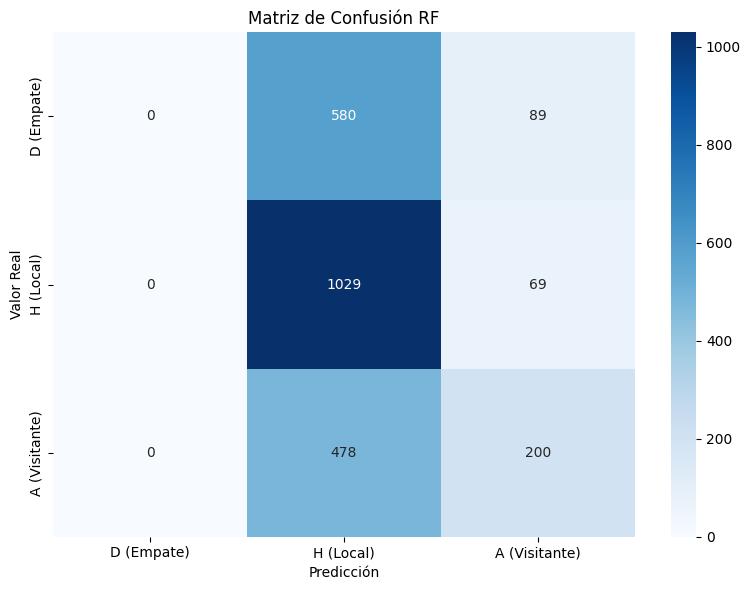

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el clasificador Random Forest
rf = RandomForestClassifier(random_state=42)

# Especificar la malla de parámetros
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Validación temporal
tscv = TimeSeriesSplit(n_splits=3)

# Búsqueda de hiperparámetros usando GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='accuracy', 
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Mejores hiperparámetros RF:", grid_rf.best_params_)
print("Mejor score RF:", grid_rf.best_score_)

# Entrenar el modelo final con los mejores parámetros
best_rf = grid_rf.best_estimator_

# Predicción en test
y_pred_rf = best_rf.predict(X_test)

# Métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy RF: {accuracy_rf * 100:.2f}%\n")
print("Reporte de clasificación RF:")
print(classification_report(y_test, y_pred_rf, target_names=['D (Empate)', 'H (Local)', 'A (Visitante)']))

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['D (Empate)', 'H (Local)', 'A (Visitante)'],
    yticklabels=['D (Empate)', 'H (Local)', 'A (Visitante)']
)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión RF')
plt.tight_layout()
plt.show()

**Valoración de los Resultados con Random Forest**  

1. **Precisión global (Accuracy)**  
   El modelo RF alcanza un **50%** de acierto, un poco por debajo del obtenido con XGBoost. Este nivel no supera de forma significativa el comportamiento de un clasificador “siempre local” (~49 %), por lo que su utilidad práctica es limitada si se busca un sistema equilibrado.

2. **Desbalance de clases persistente**  
   - **Empates (D):** precision=0, recall=0 → el modelo nunca predice un empate.  
   - **Victorias locales (H):** recall muy alto (0,94) pero precision mediocre (0,49), indicativo de que casi todo se etiqueta como “local”.  
   - **Victorias visitantes (A):** recall de 0,29 y precision de 0,56, mostrando también un sesgo que penaliza esta categoría.

3. **F1-score y métricas agrupadas**  
   - **F1_macro = 0,34**, similar al 0,36 de XGBoost, confirma un rendimiento desequilibrado entre clases.  
   - **F1_weighted = 0,40**, apenas mejora el balance global, pues la clase mayoritaria (H) domina el cálculo.

4. **Matriz de confusión**  
   Se observa que:  
   - Los **669 empates** del test se dividen en 580 predicciones “H” y 89 “A”, sin un solo “D”.  
   - De los **1 098 partidos locales**, 1 029 se clasifican correctamente y 69 como “visitante”.  
   - De los **678 partidos visitantes**, 478 se confunden con “local” y solo 200 se identifican como “A”.

5. **Conclusión**  
   Random Forest repite el principal problema detectado con XGBoost: **ignora la clase Empate** y favorece de forma abrumadora la predicción de victorias locales. Aunque la accuracy se mantenga similar, el modelo no es capaz de capturar los resultados igualados, lo cual es crítico en el contexto de LaLiga.

# 3. SVC

Y por último vamos a realizar el entrenamiento con el algoritmo SVC.

Una vez entrenado el modelo, evaluamos su desempeño en el conjunto de prueba:  
- Se calculará la exactitud (accuracy)  
- Se mostrará el **classification report**  
- Se generará y visualizará la matriz de confusión

Mejores hiperparámetros SVC: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mejor score SVC: 0.5091380250954719

Accuracy SVC: 49.86%

Reporte de clasificación SVC:
               precision    recall  f1-score   support

   D (Empate)       0.50      0.01      0.01       669
    H (Local)       0.49      0.95      0.64      1098
A (Visitante)       0.59      0.26      0.36       678

     accuracy                           0.50      2445
    macro avg       0.52      0.40      0.34      2445
 weighted avg       0.52      0.50      0.39      2445



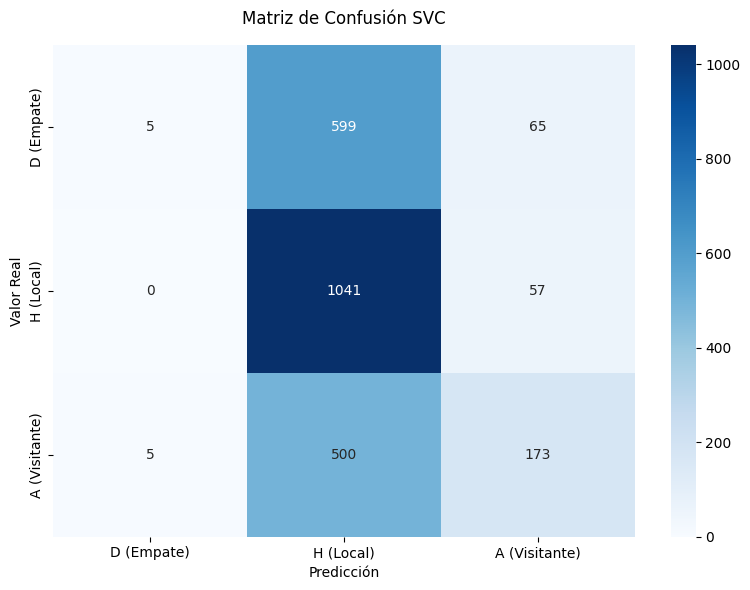

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Definimos el clasificador SVC
svc = SVC(decision_function_shape='ovo', probability=False, random_state=42)

# Especificamos la malla de hiperparámetros
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]           # solo relevante si kernel='poly'
}

# Creamos el splitter temporal para no filtrar futuro en el entrenamiento
tscv = TimeSeriesSplit(n_splits=3)

# GridSearchCV 
grid_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1
)
grid_svc.fit(X_train, y_train)

print("Mejores hiperparámetros SVC:", grid_svc.best_params_)
print("Mejor score SVC:", grid_svc.best_score_)

# Entrenamos el modelo final con los mejores parámetros
best_svc = grid_svc.best_estimator_

# Predicción en el conjunto de test
y_pred_svc = best_svc.predict(X_test)

# Evaluación: accuracy, reporte de clasificación y matriz de confusión
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"\nAccuracy SVC: {accuracy_svc * 100:.2f}%\n")

print("Reporte de clasificación SVC:")
print(classification_report(
    y_test,
    y_pred_svc,
    target_names=['D (Empate)', 'H (Local)', 'A (Visitante)']
))

cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_svc,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['D (Empate)', 'H (Local)', 'A (Visitante)'],
    yticklabels=['D (Empate)', 'H (Local)', 'A (Visitante)']
)

plt.title('Matriz de Confusión SVC', pad=15)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

**Valoración de los Resultados Obtenidos con SVC**  

1. **Precisión global**  
   El clasificador SVC alcanza un **49%** de acierto, ligeramente inferior al XGBoost y al Random Forest.  

2. **Desbalance de clases**  
   - **Empates (D):** precision=0,50 pero recall=0,01 (f1=0,01). El modelo solo detecta correctamente **5 de los 669 empates**, por lo que sigue prácticamente ignorando esta categoría.  
   - **Victorias locales (H):** recall=0,95 con precision=0,49 (f1=0,64). La mayoría de partidos —también visitantes y empates— se etiquetan como “local”.  
   - **Victorias visitantes (A):** recall=0,26 y precision=0,59 (f1=0,36). Aunque mejora ligeramente la detección de “A” frente a RF y XGBoost, aún predomina la clase “H”.

3. **Matriz de confusión**  
   - De los **1 098** partidos locales, **1 041** se clasifican correctamente como “H” y **57** como “A”.  
   - De los **678** partidos visitantes, solo **173** se etiquetan como “A”, mientras **500** se confunden con “H” y **5** con “D”.  
   - De los **669** empates, **599** se predicen como “H” y **65** como “A”.

4. **Interpretación**  
   SVC evidencia el mismo patrón de sesgo hacia la victoria local y la casi total omisión de la clase empate, lo que se refleja en un **f1_macro=0,34** y un **f1_weighted=0,39** muy desequilibrados.

## Comparativa de Modelos

Tras evaluar los tres enfoques —XGBoost, Random Forest y SVC— con las mismas particiones temporales de entrenamiento y test, la comparación arroja los siguientes hallazgos:

1. **Precisión global**  
   - **XGBoost** obtiene la mayor accuracy (50,9 %), seguido de **Random Forest** (50,3 %) y **SVC** (49,9 %). Esta ligera ventaja posiciona a XGBoost como el clasificador más eficaz para capturar patrones generales de resultados, si bien la mejora es modesta.

2. **Equilibrio entre clases**  
   - Ninguno de los tres modelos consigue predecir empates con fiabilidad: el recall para “Empate” oscila entre 0,0–0,01 en los tres casos, lo que implica que casi todos los empates se clasifican incorrectamente.  
   - La clase “Victoria Local” domina las predicciones de forma excesiva (recall ≈ 0,91–0,95), mientras que la de “Victoria Visitante” apenas alcanza un recall de 0,26–0,38.

3. **F1-score macro**  
   - El valor más alto corresponde a **XGBoost** (≈ 0,37), por encima de Random Forest y SVC (≈ 0,34), lo que confirma su mejor balance global, aunque todavía alejado del ideal (0,60–0,70).

4. **Selección del mejor modelo**  
   - **XGBoost** se impone como la opción preferente al combinar la máxima precisión y el mejor f1_macro. No obstante, el desempeño de las tres técnicas revela una incapacidad común para identificar empates, lo que limita su aplicabilidad práctica tal cual están configuradas.

5. **Recomendaciones finales**  
   - **Ponderación y remuestreo**: aplicar pesos de clase y/o técnicas de oversampling para equilibrar la frecuencia de empates.  
   - **Optimización de métrica**: emplear `f1_macro` o `balanced_accuracy` en la búsqueda de hiperparámetros.  
   - **Calibración de umbrales**: usar `CalibratedClassifierCV` para ajustar los puntos de corte y elevar el recall de empates.  

En definitiva, **XGBoost** destaca ligeramente sobre Random Forest y SVC, pero todos los modelos requieren ajustes adicionales para lograr un clasificador equilibrado y fiable en las tres categorías (Victoria Local, Empate y Victoria Visitante).

NOTA: En el caso del clasificador SVC, podría haber contribuido al bajo rendimiento el hecho de no aplicar ninguna normalización de las variables. Dado que los SVM miden distancias en el espacio de características, la falta de escalado puede hacer que aquellas con rangos más amplios dominen la función de kernel, dificultando la optimización del hiperplano y empeorando la capacidad de generalización.

## Mejora modelo XGBoost.

Vamos a mejorar el modelo XGBoost que hemos creado anteriormente aplicando las siguiente mejoras para aumentar los resultados de la clase `Empate`.

1. Sobremuestreamos la clase “Empate” usando RandomOverSampler para equilibrar el entrenamiento.

2. Optimizamos la búsqueda de hiperparámetros de XGBoost con scoring='f1_macro'.

3. Calibramos las probabilidades finales con CalibratedClassifierCV para ajustar mejor el umbral de decisión.

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Mejor f1_macro (CV): 0.4033181041323295

Accuracy calibrado: 43.15%

Reporte de clasificación calibrado:
               precision    recall  f1-score   support

   D (Empate)       0.29      0.51      0.37       669
    H (Local)       0.57      0.55      0.56      1098
A (Visitante)       0.51      0.16      0.24       678

     accuracy                           0.43      2445
    macro avg       0.46      0.41      0.39      2445
 weighted avg       0.48      0.43      0.42      2445



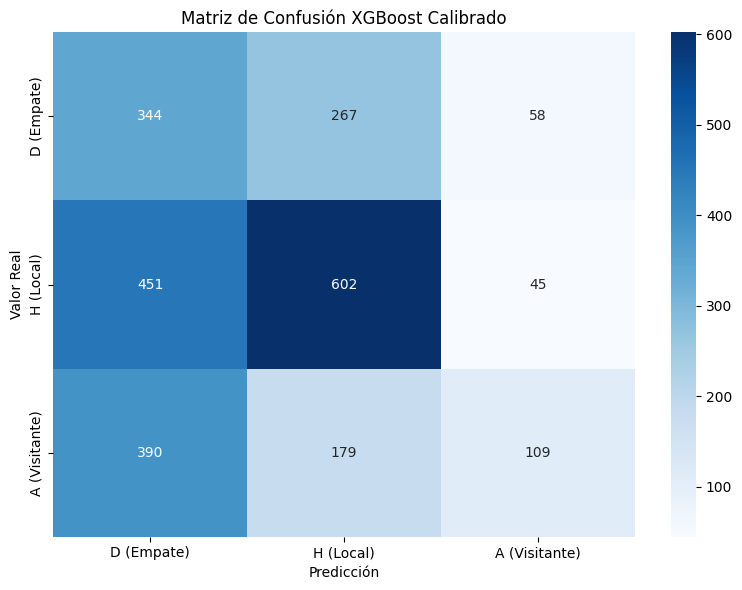

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Sobremuestreo de la clase minoritaria
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)

X_res, y_res = ros.fit_resample(X_train, y_train)

# Definición del clasificador XGBoost
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Malla de hiperparámetros y splitter temporal
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
tscv = TimeSeriesSplit(n_splits=3)

# Búsqueda de hiperparámetros optimizando f1_macro
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_res, y_res)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor f1_macro (CV):", grid.best_score_)

# Modelo final XGBoost con oversampling
best_xgb = grid.best_estimator_

# Calibración de probabilidades
calibrator = CalibratedClassifierCV(best_xgb, cv=tscv, method='isotonic')
calibrator.fit(X_res, y_res)

# Predicción y evaluación en test
y_pred = calibrator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy calibrado: {accuracy*100:.2f}%\n")
print("Reporte de clasificación calibrado:")
print(classification_report(
    y_test, y_pred,
    target_names=['D (Empate)','H (Local)','A (Visitante)']
))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['D (Empate)','H (Local)','A (Visitante)'],
    yticklabels=['D (Empate)','H (Local)','A (Visitante)']
)
plt.title('Matriz de Confusión XGBoost Calibrado')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

**Valoración de la versión calibrada y sobremuestreada de XGBoost**  

Tras aplicar oversampling de empates, optimizar por f1_macro y calibrar con `CalibratedClassifierCV`, los resultados en el conjunto de prueba son:

1. **Mejora en empates**  
   - El recall de “Empate” pasa de casi 0 a **0,51**, lo que indica que ahora el modelo identifica la mitad de los empates reales.  
   - El f1-score para esa clase sube de 0,01 a **0,37**, confirmando un mejor equilibrio.

2. **Equilibrio global**  
   - El f1_macro mejora de 0,37 a **0,39**, lo que muestra un avance hacia una predicción más balanceada entre las tres categorías.  
   - Sin embargo, la **accuracy cae** de ≈51 % a **43%**, reflejando el coste de equilibrar las clases: se penalizan más las victorias locales correctas para evitar el sesgo.

3. **Desafíos pendientes**  
   - Aún existe un sesgo residual hacia la localía: muchas tablas y victorias visitantes se siguen confundiendo con “H”.  
   - La detección de “Visitante” continúa siendo la más débil (recall 0,16), por lo que esa clase requiere señal adicional.

## Interpretabilidad. SHAP

SHAP (SHapley Additive exPlanations) permite descomponer la predicción de un modelo en la contribución numérica de cada variable. Se fundamenta en los valores de Shapley de la teoría de juegos, que asignan de forma “justa” la diferencia entre la predicción individual y una predicción de base (por ejemplo, la probabilidad media de victoria local) entre todas las características.  

Al aplicarlo a nuestros modelos (XGBoost, Random Forest, SVC), SHAP aporta tres ventajas clave:  
- **Explicaciones locales coherentes**: para cada partido, se identifican las variables (racha de los últimos cinco encuentros, historial H2H, rendimiento a largo plazo…) que más empujan la predicción hacia “victoria local”, “empate” o “victoria visitante”.  
- **Unificación local-global**: las mismas contribuciones individuales pueden agregarse para generar gráficos de importancia media, dependencias y efectos de interacción, lo que facilita descubrir qué características son decisivas en la clasificación multiclase.  
- **Eficiencia y claridad**: con la implementación **TreeSHAP**, la estimación es muy rápida para modelos de árbol y genera visualizaciones sencillas (force plots, summary plots, dependence plots) que documentan de forma transparente cómo cada variable influye en el resultado.

Aunque XGBoost, Random Forest, SVC son modelos “no interpretables” de forma nativa (es decir, no te explican por sí mismos por qué hacen cada predicción), podemos usar SHAP para obtener explicaciones “post-hoc” de estos modelos. En otras palabras, XGBoost sigue siendo un “caja negra” a nivel de logits o reglas internas, pero SHAP (SHapley Additive exPlanations) calcula valores de atribución que nos indican cuánto aporta cada característica a cada predicción individual, o de forma global.

Note: you may need to restart the kernel to use updated packages.


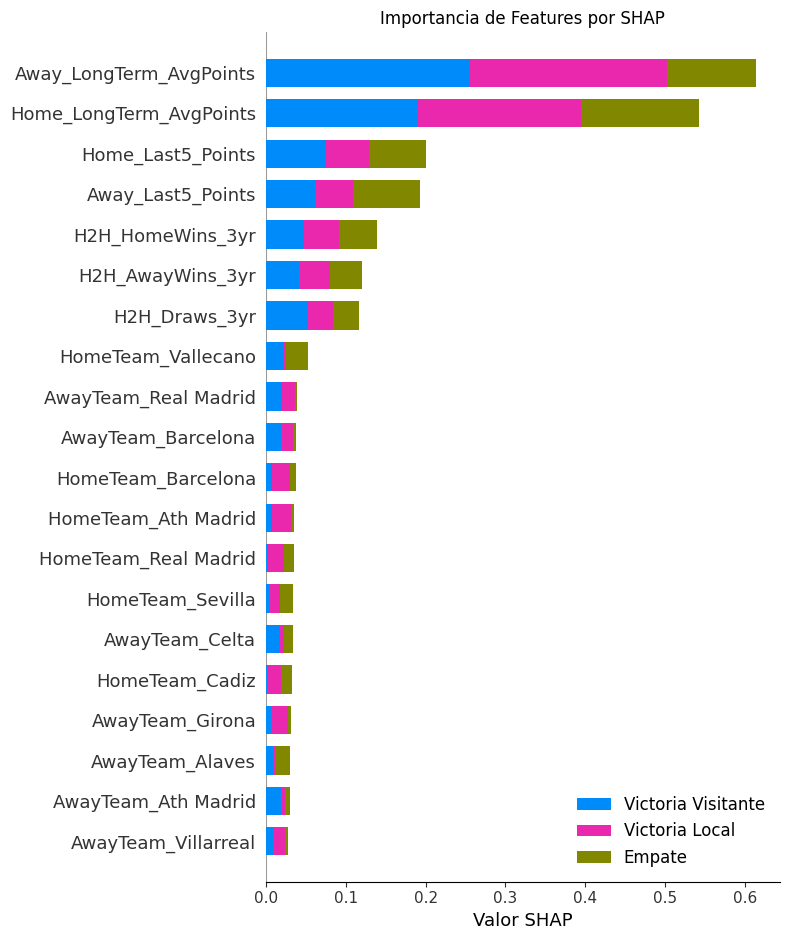

In [27]:
%pip install shap

import shap
import matplotlib.pyplot as plt

# Crear el TreeExplainer sobre el modelo XGBoost calibrado y optimizado
explainer = shap.TreeExplainer(best_xgb)

# Calcular los valores SHAP para el conjunto de datos
shap_values = explainer.shap_values(X_test)

# Gráfico de importancia global de características
plt.figure(figsize=(8, 8))
shap.summary_plot(
    shap_values, 
    X_test, 
    plot_type="bar", 
    class_names=['Empate', 'Victoria Local', 'Victoria Visitante'],
    show=False
)
plt.title("Importancia de Features por SHAP")
plt.xlabel("Valor SHAP")
plt.tight_layout()
plt.show()

Del análisis del gráfico actualizado se extraen las siguientes conclusiones:

1. **Predominio de las métricas históricas**

   * Tanto **Away\_LongTerm\_AvgPoints** como **Home\_LongTerm\_AvgPoints** son las variables con mayor valor medio SHAP en las tres clases (victoria visitante, victoria local y empate).
   * Esto revela que el modelo fundamenta principalmente su decisión en la consistencia de cada equipo a lo largo de las temporadas (puntos medios históricos).

2. **Relevancia secundaria de la forma reciente**

   * **Home\_Last5\_Points** y **Away\_Last5\_Points** conforman el segundo grupo de mayor impacto, con valores SHAP aproximadamente la mitad de los históricos a largo plazo.
   * Ello indica que, aunque la dinámica de los últimos cinco encuentros influye, su peso es menor que la tendencia acumulada, aportando un ajuste de corto plazo al pronóstico.

3. **Contribución moderada del enfrentamiento directo**

   * Las variables **H2H\_HomeWins\_3yr**, **H2H\_Draws\_3yr** y **H2H\_AwayWins\_3yr** presentan valores SHAP intermedios, pero claramente inferiores a las métricas de forma.
   * El modelo incorpora el historial de duelos, pero lo valora menos que el rendimiento global o reciente de los equipos.

4. **Impacto residual de la identidad de club**

   * Los indicadores one-hot de equipo (todas las columnas `HomeTeam_…` y `AwayTeam_…`) muestran un valor SHAP casi nulo.
   * Se deduce que el algoritmo no está aprendiendo un sesgo particular hacia ningún club en concreto; prima el “cómo juegan” por encima del “quiénes son”.

5. **Diferencias por clase de resultado**

   * **Victoria visitante (azul):** el segmento azul alcanza su máxima longitud en las métricas históricas, lo que significa que un visitante con alto promedio de puntos genera mayor “fuerza” para predecir triunfo fuera.
   * **Victoria local (rosa):** el rosa mantiene un impacto elevado en las mismas métricas históricas, confirmando que la localía basada en rendimiento pasado “empuja” la predicción hacia victorias en casa.
   * **Empate (oliva):** aunque el segmento oliva crece ligeramente en ambas métricas de forma histórica, nunca supera a los colores de victoria, reflejando que el empate se predice sobre todo en escenarios de rendimientos equilibrados.

En conjunto, el gráfico demuestra que las **features de rendimiento histórico** y **forma reciente** son las palancas principales del modelo: XGBoost aprende sobre todo a partir de los puntos medios acumulados y la racha de los últimos cinco partidos, relegando a un segundo plano los enfrentamientos directos y prácticamente descartando la identidad pura de cada club.


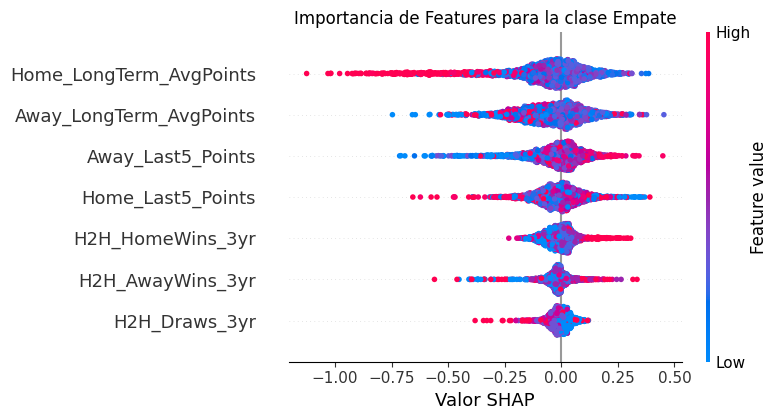

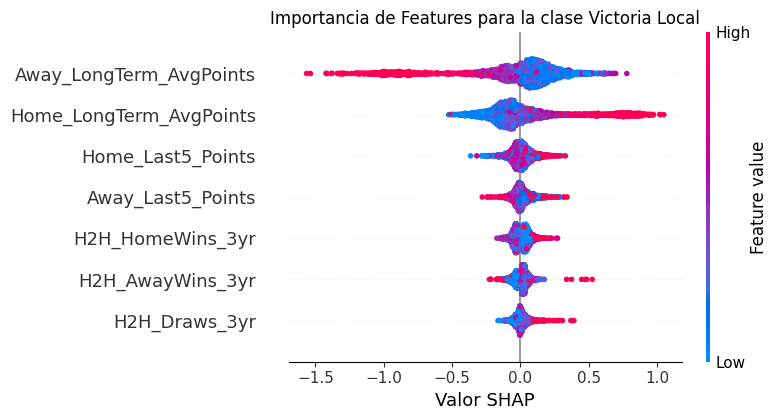

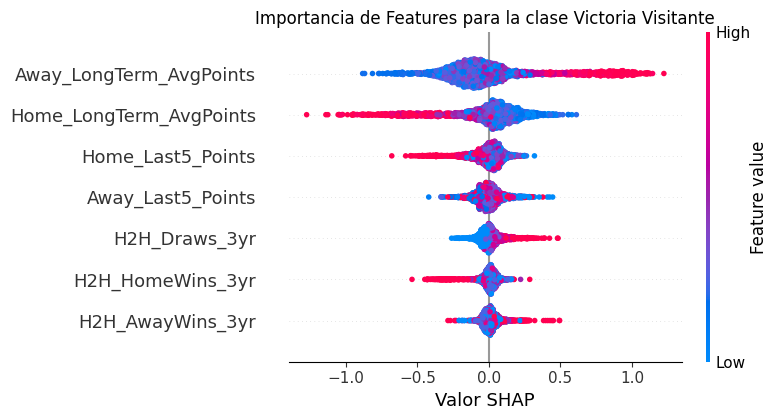

In [28]:
for i in range(3):
    if i == 0:
        class_name = "Empate"
    elif i == 1:
        class_name = "Victoria Local"
    else:
        class_name = "Victoria Visitante"
    shap.summary_plot(shap_values[:,:,i], X_test, max_display=7, feature_names=features, show=False)
    plt.title("Importancia de Features para la clase {}".format(class_name))
    plt.xlabel("Valor SHAP")
    plt.tight_layout()
    plt.show()

A partir de los tres diagramas de violín SHAP por clase se extraen las siguientes conclusiones:

### 1. Clase “Empate”

1. **Influencia de las métricas históricas**

   * Ni “Home\_LongTerm\_AvgPoints” ni “Away\_LongTerm\_AvgPoints” presentan contribuciones muy elevadas al empatar, y sus valores altos (puntos promedio elevados) tienden incluso a desplazar la predicción fuera de la clase “Empate”.
   * En cambio, valores moderados de estas métricas (ni muy altos ni muy bajos) se asocian con shap values cercanos a cero o ligeramente positivos, indicando que un rendimiento histórico equilibrado favorece predecir un empate.

2. **Papel de la forma reciente**

   * Tanto “Home\_Last5\_Points” como “Away\_Last5\_Points” muestran distribuciones centradas alrededor de cero y con cola simétrica, lo que sugiere que la racha inmediata solo aporta un ligero matiz a la predicción de empates y no desplaza drásticamente la probabilidad.

3. **Contribución de los enfrentamientos directos**

   * Las variables “H2H\_Draws\_3yr”, “H2H\_HomeWins\_3yr” y “H2H\_AwayWins\_3yr” aparecen con shap values muy próximos a cero, confirmando que los empates previos entre ambos equipos tienen un efecto marginal en la predicción de un nuevo empate.

---

### 2. Clase “Victoria Local”

1. **Dominio de la consistencia histórica**

   * “Home\_LongTerm\_AvgPoints” es la variable que ejerce el mayor empuje positivo hacia “Victoria Local”: cuantos más puntos promedio haya cosechado el equipo local a lo largo de las temporadas, mayor es la contribución al log-odds de ganar en casa.
   * Por su parte, “Away\_LongTerm\_AvgPoints” provoca shap values negativos cuando sus valores son altos, reduciendo la probabilidad de triunfo local si el visitante también muestra un largo historial de éxito.

2. **Refuerzo por forma reciente**

   * “Home\_Last5\_Points” aporta shap values preferentemente positivos para valores altos, reforzando la predicción de victoria local cuando el equipo local llega en buena racha.
   * La influencia de “Away\_Last5\_Points” es más débil y bidireccional: una mala racha visitante potencia ligeramente el triunfo local, pero los efectos son menores que los de la forma propia.

3. **Contribución secundaria del H2H**

   * Los partidos directos ganados por el local en los últimos tres años (“H2H\_HomeWins\_3yr”) generan shap values levemente positivos, aunque claramente por debajo de las métricas de puntos.
   * Los empates y las victorias visitantes en el H2H apenas modifican la probabilidad de victoria local, situándose casi a ras de suelo.

---

### 3. Clase “Victoria Visitante”

1. **Relevancia del rendimiento foráneo acumulado**

   * “Away\_LongTerm\_AvgPoints” encabeza las contribuciones positivas: cuanto mejor ha sido históricamente el equipo visitante, mayor es el impulso hacia una predicción de triunfo fuera de casa.
   * Simétricamente, “Home\_LongTerm\_AvgPoints” altos generan shap values negativos, desplazando la predicción lejos de “Victoria Visitante”.

2. **Menor peso de la forma inmediata**

   * “Away\_Last5\_Points” muestra shap values positivos para valores altos, pero con amplitud reducida en comparación con su versión local.
   * “Home\_Last5\_Points” apenas afecta la probabilidad visitante, confirmando que la racha del local tiene escasa capacidad para frenar un visitante “en forma”.

3. **Efecto reducido del H2H**

   * Las tres métricas de head-to-head (“H2H\_AwayWins\_3yr”, “H2H\_Draws\_3yr”, “H2H\_HomeWins\_3yr”) apenas mueven la aguja para la clase visitante, situándose todas en shap values muy próximos a cero.

---

**Conclusión común**
En los tres casos, las dos métricas de rendimiento histórico a largo plazo —promedio de puntos local y visitante— dominan la orientación de la predicción, mientras que la forma reciente y los resultados directos actúan como refinadores de la probabilidad final, modulando los desenlaces sin sustituir al “termómetro” global.


# Simulación: Predicción de la Clasificación Final en las Últimas 10 Jornadas

Es hora de poner en práctica el modelo entrenado, para ello en un escenario real, a falta de 10 jornadas para finalizar la temporada se cuenta con la posición actual y se predicen los resultados de cada partido de esas jornadas.  
Para esta simulación usaremos un nuevo dataset en el que contiene los últimos 10 partidos de cada equipo y:
- Asignaremos puntos en función de la predicción del modelo:
  - Victoria local (clase 1): 3 puntos al local, 0 al visitante.
  - Empate (clase 0): 1 punto para ambos equipos.
  - Victoria visitante (clase 2): 0 puntos al local, 3 al visitante.
- Simularemos la tabla jornada a jornada sumando estos puntos a una tabla actual .

> **Nota:** La simulación real requeriría actualizar de forma secuencial (jornada a jornada) las estadísticas y la forma de cada equipo.  

In [29]:
# =============================================================================
# Función para calcular la clasificación a partir del dataset original
# =============================================================================
def compute_standings(df, from_date, to_date):
    """
    Calcula la clasificación de la liga utilizando el dataset original considerando solo los partidos jugados entre 'from_date' y 'to_date' (inclusive).
    
    Retorna un DataFrame con las columnas:
      - Team
      - Played: Partidos jugados.
      - Wins: Número de victorias.
      - Draws: Número de empates.
      - Losses: Número de derrotas.
      - Points: Puntos acumulados (3 por victoria, 1 por empate).
      
    El DataFrame se ordena por puntos de forma descendente y, en caso de empate, se utiliza el número de victorias.
    """
    
    # Filtra los partidos por la fecha de inicio y fin (inclusive)
    df_filtered = df[(df['Date'] >= from_date) & (df['Date'] <= to_date)]

    # Obtener la lista de equipos únicos en el DataFrame filtrado
    teams = pd.concat([df_filtered['HomeTeam'], df_filtered['AwayTeam']]).unique()
    
    # Crear Dataframe de clasificación vacío
    standings = pd.DataFrame({'Team': teams})
    standings['Played'] = 0
    standings['Wins'] = 0
    standings['Draws'] = 0
    standings['Losses'] = 0
    standings['Points'] = 0
    
    # Iterar sobre cada partido filtrado y actualizar la clasificación
    for idx, row in df_filtered.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        # La columna 'FTR' contiene el resultado final del partido, codificado: 'H' para victoria local, 'D' para empate y 'A' para victoria visitante.
        result = row['FTR']
        
        # Actualizar partidos jugados
        standings.loc[standings['Team'] == home_team, 'Played'] += 1
        standings.loc[standings['Team'] == away_team, 'Played'] += 1
        
        if result == 'H':
            standings.loc[standings['Team'] == home_team, 'Wins'] += 1
            standings.loc[standings['Team'] == away_team, 'Losses'] += 1
            standings.loc[standings['Team'] == home_team, 'Points'] += 3
        elif result == 'A':
            standings.loc[standings['Team'] == away_team, 'Wins'] += 1
            standings.loc[standings['Team'] == home_team, 'Losses'] += 1
            standings.loc[standings['Team'] == away_team, 'Points'] += 3
        else:
            standings.loc[standings['Team'] == home_team, 'Draws'] += 1
            standings.loc[standings['Team'] == away_team, 'Draws'] += 1
            standings.loc[standings['Team'] == home_team, 'Points'] += 1
            standings.loc[standings['Team'] == away_team, 'Points'] += 1
            
    # Ordenar la clasificación por puntos, y en caso de empate por número de victorias
    standings.sort_values(by=['Points', 'Wins'], ascending=False, inplace=True)
    standings.reset_index(drop=True, inplace=True)
    
    return standings

In [30]:
################################################################
# Función para aplicar one-hot encoding a la columna de equipos
################################################################
def apply_one_hot_encoding(df, team_col, team_list, prefix):
    """
    Para un DataFrame 'df' y la columna 'team_col', genera variables one-hot para cada equipo en 'team_list',
    usando el prefijo dado.
    """
    for team in team_list:
        df[f"{prefix}_{team}"] = df[team_col].apply(lambda x: 1 if x == team else 0)
    return df

#############################################################################
# Función para recalcular las features para el dataset actualizado sin goles
#############################################################################
def recalculate_features(df_hist, mask):
    """
    Recalcula las features para las filas de df_hist definidas por 'mask' (por ejemplo, los partidos nuevos) y actualiza solo esas filas sin volver a procesar todo el dataset.
    
    Parámetros:
      - df_hist: DataFrame histórico completo (sin one-hot encoding aún, con columnas originales: Date, HomeTeam, AwayTeam, Result).
      - mask: Un filtro booleano (por ejemplo, df_hist['Date'] == fecha_jornada) que indica qué filas recalcular.
      
    Retorna df_hist con las filas seleccionadas actualizadas con las nuevas features y aplica one-hot encoding solo a esas filas (agregándolas a las que ya existían).
    """
    features_list = []

    # Para cada partido en el subconjunto (nuevos partidos)
    for idx, row in df_hist.loc[mask].iterrows():
        current_date = row['Date']
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        
        # Calcular las features utilizando solo partidos anteriores a current_date
        home_recent = get_team_recent_stats(home_team, current_date, df_hist, n=5)
        away_recent = get_team_recent_stats(away_team, current_date, df_hist, n=5)
        h2h_stats   = get_head2head_stats(home_team, away_team, current_date, df_hist, years=3)
        home_longterm = get_team_longterm_avg(home_team, current_date, df_hist, years=5)
        away_longterm = get_team_longterm_avg(away_team, current_date, df_hist, years=5)
        
        feat = {
            'Home_Last5_Points': home_recent,
            'Away_Last5_Points': away_recent,
            'H2H_HomeWins_3yr': h2h_stats[0],
            'H2H_Draws_3yr': h2h_stats[1],
            'H2H_AwayWins_3yr': h2h_stats[2],
            'Home_LongTerm_AvgPoints': home_longterm,
            'Away_LongTerm_AvgPoints': away_longterm,
            # Copiamos las columnas originales para luego reintroducir las dummies
            'Date': row['Date'],
            'HomeTeam': home_team,
            'AwayTeam': away_team,
            'Result': row['Result']  # En partidos futuros, este valor estará (o seguirá) como NaN, para luego actualizarlo con la predicción.
        }
        features_list.append(feat)
    
    # Convertir a DataFrame
    df_new_features = pd.DataFrame(features_list)
    
    # Ahora, para one-hot encoding, reutilizamos la lista de equipos que existe en todo el dataset. df_hist contiene las columnas 'HomeTeam' y 'AwayTeam' originales.
    teams = pd.concat([df_hist['HomeTeam'], df_hist['AwayTeam']]).unique().tolist()
    for t in teams:
        col_home = f'HomeTeam_{t}'
        col_away = f'AwayTeam_{t}'
        # Solo actualizamos para las filas nuevas
        df_new_features[col_home] = df_new_features['HomeTeam'].apply(lambda x: 1 if x == t else 0)
        df_new_features[col_away] = df_new_features['AwayTeam'].apply(lambda x: 1 if x == t else 0)
    
    # Actualizamos en df_hist (las filas indicadas por 'mask') las nuevas columnas calculadas.
    for col in df_new_features.columns:
        df_hist.loc[mask, col] = df_new_features[col].values
    
    return df_hist

In [31]:
# Generamos Dataframe de las últimas 10 jornadas de la liga española
df_future_matches = pd.DataFrame({
    'Round' : np.repeat(np.arange(29, 39), 10),
    'Date' : pd.to_datetime(np.concatenate((np.repeat("2025-03-30", 10),np.repeat("2025-04-06", 10),np.repeat("2025-04-13", 10),np.repeat("2025-04-20", 10),np.repeat("2025-04-24", 10),
                        np.repeat("2025-05-04", 10),np.repeat("2025-05-11", 10),np.repeat("2025-05-14", 10),np.repeat("2025-05-18", 10),np.repeat("2025-05-25", 10)))),
    'HomeTeam' : ['Sociedad','Espanol','Alaves','Real Madrid','Getafe','Barcelona','Ath Bilbao','Valencia','Betis', 'Celta',
                  'Vallecano','Girona','Real Madrid','Mallorca','Barcelona','Las Palmas','Sevilla','Valladolid','Villarreal','Leganes',
                  'Valencia','Sociedad','Getafe','Celta','Leganes','Osasuna','Alaves','Betis','Ath Bilbao','Ath Madrid',
                  'Espanol','Vallecano','Barcelona','Mallorca','Las Palmas','Valladolid','Villarreal','Sevilla','Real Madrid','Girona',
                  'Valencia','Barcelona','Ath Bilbao','Celta','Alaves','Getafe','Leganes','Osasuna','Ath Madrid','Betis',
                  'Vallecano','Alaves','Villarreal','Las Palmas','Real Madrid','Valladolid','Sevilla','Espanol','Sociedad','Girona',
                  'Ath Bilbao','Ath Madrid','Barcelona','Celta','Girona','Las Palmas','Leganes','Mallorca','Betis','Valencia',
                  'Alaves','Getafe','Osasuna','Vallecano','Real Madrid','Sociedad','Valladolid','Sevilla','Espanol','Villarreal',
                  'Ath Madrid','Barcelona','Celta','Las Palmas','Mallorca','Osasuna','Sociedad','Valladolid','Sevilla','Valencia',
                  'Alaves','Ath Bilbao','Getafe','Girona','Leganes','Vallecano','Betis','Real Madrid','Espanol','Villarreal',],
    'AwayTeam' : ['Valladolid','Ath Madrid','Vallecano','Leganes','Villarreal','Girona','Osasuna','Mallorca','Sevilla','Las Palmas',
                  'Espanol','Alaves','Valencia','Celta','Betis','Sociedad','Ath Madrid','Getafe','Ath Bilbao','Osasuna',
                  'Sevilla','Mallorca','Las Palmas','Espanol','Barcelona','Girona','Real Madrid','Villarreal','Vallecano','Valladolid',
                  'Getafe','Valencia','Celta','Leganes','Ath Madrid','Osasuna','Sociedad','Alaves','Ath Bilbao','Betis',
                  'Espanol','Mallorca','Las Palmas','Villarreal','Sociedad','Real Madrid','Girona','Sevilla','Vallecano','Valladolid',
                  'Getafe','Ath Madrid','Osasuna','Valencia','Celta','Barcelona','Leganes','Betis','Ath Bilbao','Mallorca',
                  'Alaves','Sociedad','Real Madrid','Sevilla','Villarreal','Vallecano','Espanol','Valladolid','Osasuna','Getafe',
                  'Valencia','Ath Bilbao','Ath Madrid','Betis','Mallorca','Celta','Girona','Las Palmas','Barcelona','Leganes',
                  'Betis','Villarreal','Vallecano','Leganes','Getafe','Espanol','Girona','Alaves','Real Madrid','Ath Bilbao',
                  'Osasuna','Barcelona','Celta','Ath Madrid','Valladolid','Mallorca','Valencia','Sociedad','Las Palmas','Sevilla',]
})

df_future_matches

,Round,Date,HomeTeam,AwayTeam
0,29,2025-03-30,Sociedad,Valladolid
1,29,2025-03-30,Espanol,Ath Madrid
2,29,2025-03-30,Alaves,Vallecano
3,29,2025-03-30,Real Madrid,Leganes
4,29,2025-03-30,Getafe,Villarreal
...,...,...,...,...
95,38,2025-05-25,Vallecano,Mallorca
96,38,2025-05-25,Betis,Valencia
97,38,2025-05-25,Real Madrid,Sociedad
98,38,2025-05-25,Espanol,Las Palmas


In [32]:
# Se guarda df en un archivo csv para pruebas
df.to_csv('df.csv', index=False)

In [33]:
# Solo para pruebas
# df = pd.read_csv('df.csv')
# df["Date"] = pd.to_datetime(df["Date"])
# df.sort_values(by="Date", inplace=True)

# #####################################################################
# # Simulación jornada a jornada
# #####################################################################

# Para cada jornada (batch de 10 partidos):
# - Se predicen los resultados usando el mejor modelo.
# - Se agregan esos partidos al dataset histórico 'df' (solo con 'Date', 'HomeTeam', 'AwayTeam', 'Result'), donde el valor 'result' es el resultado predicho.
# - Se recalculan las features para el dataset actualizado y se aplica one-hot encoding para obtener 'df_features'.
# - Se muestra la clasificación calculada desde season_start hasta la fecha de la jornada actual.

# Generar la clasificación actual a partir del dataset original
df_current_standings = compute_standings(df, pd.Timestamp('2024-08-15'), pd.Timestamp('2025-03-27'))
df_current_standings.index = df_current_standings.index + 1 
print("\n ##### Clasificación Jornada 28 #####")
print(df_current_standings)

print("\n --- Simulación de jornadas ---")
# Iteramos jornada a jornada
for round_num in sorted(df_future_matches['Round'].unique()):
    print(f"\n     --- Partidos Jornada {round_num} ---")
    # Extraer los partidos de la jornada actual
    df_round_matches = df_future_matches[df_future_matches['Round'] == round_num]
    df_round_matches['Result'] = np.nan
    print(df_round_matches[['HomeTeam', 'AwayTeam']].to_string(index=False))
    
    # Cogemos el dataset histórico df y los 10 partidos de la jornada actual y los unimos en el dataset actualizado 'df_updated'
    df_updated = pd.concat([df_round_matches.drop(columns=['Round']), df], ignore_index=True)
    df_updated.sort_values('Date', inplace=True)
    df_updated.reset_index(drop=True, inplace=True)
    
    # Recalcular las features para el dataset actualizado (df_updated)
    print(f"\n     Recalculando features jornada {round_num}...")
    date_round = df_round_matches['Date'].max() # fecha jornada actual
    mask = (df_updated['Date'] == date_round)
    df_updated = recalculate_features(df_updated, mask)
    
    # Seleccionamos los 10 partidos de la jornada actual
    new_matchs = df_updated.tail(10)
    
    print(f"\n     Prediciendo resultados jornada {round_num}...")
    for idx, match in new_matchs.iterrows():
        
        X_match = match[features].to_frame().T
        X_match = X_match.apply(pd.to_numeric, errors='coerce') # Nos aseguramoe que todas las columnas sean de tipo numérico
        pred = best_xgb.predict(X_match)[0]
        # Actualizamos en df_updated (para la fila correspondiente a esta fecha y equipos) el valor de 'Result'. Filtramos por equipos y fecha
        condition = ((df_updated['Date'] == match['Date']) &
                     (df_updated['HomeTeam'] == match['HomeTeam']) &
                     (df_updated['AwayTeam'] == match['AwayTeam']))
        df_updated.loc[condition, 'Result'] = pred
        
        # Agregamos cada partido al dataset histórico 'df'
        df_X_match = X_match[['Home_Last5_Points','Away_Last5_Points','H2H_HomeWins_3yr', 'H2H_Draws_3yr','H2H_AwayWins_3yr','Home_LongTerm_AvgPoints','Away_LongTerm_AvgPoints']]
        df_X_match['Date'] = match['Date']
        df_X_match['HomeTeam'] = match['HomeTeam']
        df_X_match['AwayTeam'] = match['AwayTeam']
        df_X_match['Result'] = pred
        if pred == 1:
            df_X_match['FTR'] = 'H'
        elif pred == 2:
            df_X_match['FTR'] = 'A'
        else:
            df_X_match['FTR'] = 'D'
        df = pd.concat([df, df_X_match], ignore_index=True)
            
    # Mostramos resultados de cada jornada
    print(f"\n     --- Resultados Jornada {round_num} ---")
    print(df_updated[['HomeTeam', 'AwayTeam','Result']].tail(10).to_string(index=False))
    
    # Generamos clasificación de cada jornada
    df_current_standings = compute_standings(df, pd.Timestamp('2024-08-15'), new_matchs['Date'].unique()[0])
    df_current_standings.index = df_current_standings.index + 1 
    print(f"\n ##### Clasificación Jornada {round_num} #####")
    print(df_current_standings)    



 ##### Clasificación Jornada 28 #####
           Team  Played  Wins  Draws  Losses  Points
1     Barcelona      28    20      3       5      63
2   Real Madrid      28    18      6       4      60
3    Ath Madrid      28    16      8       4      56
4    Ath Bilbao      28    14     10       4      52
5    Villarreal      28    13      8       7      47
6         Betis      28    12      8       8      44
7      Mallorca      28    11      7      10      40
8         Celta      28    11      6      11      39
9     Vallecano      28     9     10       9      37
10      Sevilla      28     9      9      10      36
11       Getafe      28     9      9      10      36
12     Sociedad      28    10      5      13      35
13       Girona      28     9      7      12      34
14      Osasuna      28     7     12       9      33
15      Espanol      28     7      7      14      28
16     Valencia      28     6     10      12      28
17       Alaves      28     6      9      13      27
18     

Resultados finales temporada 2024/25: https://es.wikipedia.org/wiki/Primera_Divisi%C3%B3n_de_Espa%C3%B1a_2024-25#Clasificaci%C3%B3n